<div style=" background-color: RGB(217, 83, 26);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">PROJET 9 - Produisez une étude de marché avec R ou Python</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center"> Clustering & ACP</h2>
</div>

Nous faisons une première CAH avec nos variables et contrôlerons 
la classification rendue afin de s'assurer que les données sont
suffisament alimentées. Le cas échéant, nous ajouterons des indicateurs
supplémentaires pour améliorer la classification proposée par l'algorithme.

<div style="background-color: RGB(217, 117, 26);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">I - Première Classification Ascendante Hiérarchique</h2>
</div>

In [1]:
# Importation librairies
import os
os.environ["OMP_NUM_THREADS"] = '1'

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(10)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
# Fonctions
def description_table(data) :
    print('Le fichier comporte {} observation(s) ou article(s).'
      .format(data.shape[0]))
    print('Le fichier comporte {} colonne(s).'
          .format(data.shape[1]), '\n')
    print('\nTypes de données : \n',data.dtypes, '\n')
    print('\nNombre de valeurs uniques : \n',data.nunique(),'\n')
    print(f"\nY a-t-il des doublons : \n {data.duplicated().any()}")
    print(f"\nY a-t-il des valeurs manquantes : \n {data.isna().any()}")
    print(f"\nY a-t-il des valeurs nulles : \n {data.isnull().any()}")
    
# Fonction pour contrôler les manquants du df entier
def manquants(df) :
    return(df.isna().sum())
    
# Fonction pour calculer la proportion de données manquantes
def missing_data(liste_var,df) :
    for var in liste_var :
        print(var,' --- Proportion :',round(((df[var].isna().sum()) / len(df[var]) * 100), 2),'%')

In [3]:
# Importation du df
bilan_pop_2017 = pd.read_csv('bilan_pop_2017.csv', sep=",")
select_var = pd.read_csv('select_var.csv', sep=",")

In [4]:
col = bilan_pop_2017[['Unnamed: 0','Année','Dispo (Kcal/jour)','Dispo mat. grasses (g/jour)',
                      'Dispo protéines (g/jour)','Résidus', 'Variation de stock']]
bilan_pop_2017 = bilan_pop_2017.drop(columns=col)

<div style=" background-color: RGB(217, 146, 26);" >
<div style="border: 1px solid RGB(217, 146, 26);" >
<h3 style="margin: auto; padding: 20px; color: #fff"> I.I - Définir X</h3>
</div>

In [5]:
# Garder les zones dans une variable (les sujets)
zone = bilan_pop_2017.Zone.values
zone

array(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie', 'Australie', 'Autriche', 'Azerbaïdjan', 'Bahamas',
       'Bangladesh', 'Barbade', 'Bélarus', 'Belgique', 'Belize', 'Bénin',
       'Bolivie (État plurinational de)', 'Bosnie-Herzégovine',
       'Botswana', 'Brésil', 'Bulgarie', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodge', 'Cameroun', 'Canada', 'Chili',
       'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao',
       'Chine, continentale', 'Chine, Taiwan Province de', 'Chypre',
       'Colombie', 'Comores', 'Congo', 'Costa Rica', "Côte d'Ivoire",
       'Croatie', 'Cuba', 'Danemark', 'Djibouti', 'Dominique', 'Égypte',
       'El Salvador', 'Émirats arabes unis', 'Équateur', 'Espagne',
       'Estonie', 'Eswatini', "États-Unis d'Amérique", 'Éthiopie',
       'Fédération de Russie', 'Fidji', 'Finlande', 'France', 'Gabon',
       'Gambie', 'Géorgie', 'Ghana', '

En ce qui concerne le choix des variables pour les CAH, nous supprimerons les variables production
et nourriture car elles sont presque parfaitement corrélées avec Dispo intérieure. Cela pourrait fausser les résultats des CAH.
Nous les réintégrerons au moment de l'ACP.

In [6]:
# Supprimer les colonnes avec du texte et les colonnes inutiles au CAH
X = bilan_pop_2017[['Dispo (kg/an)','Dispo int.', 'Export (qté)','Import (qté)', 'Dispo (hab)']]
X[:10]

,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Dispo (hab)
0,1.79,64.0,0.0,29.0,0.771432
1,37.25,2110.0,63.0,514.0,29.205528
2,11.55,33.0,0.0,20.0,4.507364
3,6.95,286.0,0.0,2.0,6.861695
4,18.06,1557.0,646.0,842.0,18.316346
5,10.51,318.0,0.0,277.0,1.341527
6,68.78,7.0,0.0,7.0,0.000000
7,36.83,1258.0,47.0,745.0,16.313618
8,44.54,1962.0,207.0,8.0,49.206662
9,15.96,46.0,0.0,35.0,3.735409


<div style=" background-color: RGB(217, 146, 26);" >
<div style="border: 1px solid RGB(217, 146, 26);" >
<h3 style="margin: auto; padding: 20px; color: #fff"> I.II - Normalisation des données</h3>
</div>

La standardisation consiste à mettre les données à l'échelle de telle sorte que la moyenne
soit égale à zéro et l'écart type égal à 1. Cela se fait en soustrayant la moyenne de chaque
point de données et en divisant par l'écart type. 

In [7]:
from sklearn.preprocessing import StandardScaler

#Fonction pour normaliser les données
def normalization (data) :
    std_scale = preprocessing.StandardScaler()
    std_scale.fit(data)
    X_scaled = std_scale.transform(data)
    return X_scaled

In [8]:
X_scaled = normalization(X)

#Contrôler que les données soient bien normalisées
pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]

,0,1,2,3,4
mean,-0.0,0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0


<div style=" background-color: RGB(217, 146, 26);" >
<div style="border: 1px solid RGB(217, 146, 26);" >
<h3 style="margin: auto; padding: 20px; color: #fff"> I.III - Calcul des distances entre les individus</h3>
</div>

In [9]:
# Calcul de la matrice de similarité/dissimilarité
linkage_matrix = linkage(X_scaled, method='ward', metric='euclidean')

In [10]:
# Fonction pour afficher le Dendrogram
def dendrogram_viz(data) :
    fig = plt.figure(figsize=(10, 6))
    dendrogram(data)
    plt.title('Dendrogramme de la Classification Ascendante Hiérarchique')
    plt.xlabel('Individus')
    plt.ylabel('Distance')
    plt.show()
    
    return fig

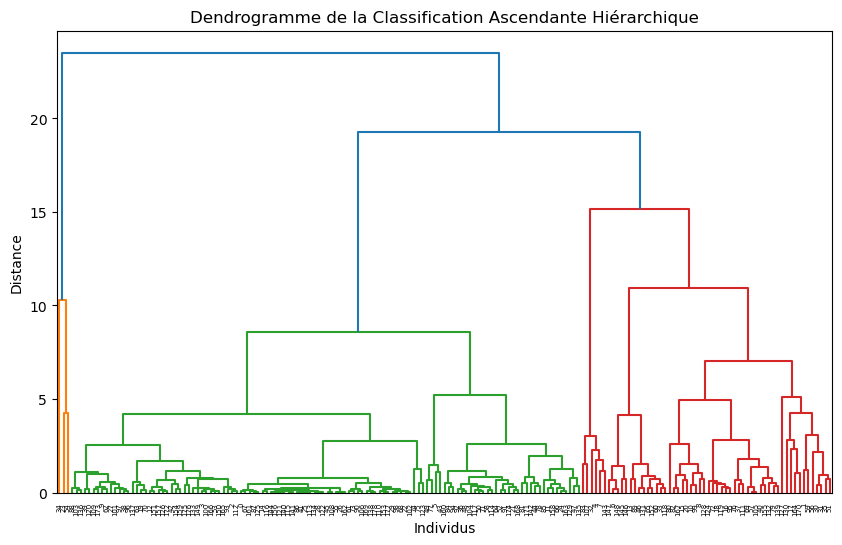

In [11]:
fig = dendrogram_viz(linkage_matrix)
fig.savefig('dendrogram_1.png', dpi=300)

On utilise la méthode du saut maximum afin de determiner le nombre optimal de cluster.
Le nombre de clusters peut être déterminé par le nombre de sauts significatifs dans le dendrogramme. Ici il est difficile de determiner le nombre optimal de cluster car les sauts sont presque tous de la même hauteur.
Vérifions cela avec un coefficiant de silhouette.

In [12]:
# Mise en place et représentation du coefficiant de silhouette
def silhouette_coeff(num,data) :
    max_clusters = num  
    silhouette_scores = []

    for num_clusters in range(2, max_clusters+1):
        clusters = fcluster(linkage(data, method='ward', metric='euclidean'), num_clusters, criterion='maxclust')
        silhouette_avg = silhouette_score(data, clusters)
        silhouette_scores.append(silhouette_avg)

    # Tracer le graphique du score de silhouette moyen pour chaque nombre de clusters
    fig = plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    plt.title("Score de silhouette moyen pour chaque nombre de clusters")
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Score de silhouette moyen")
    plt.show()
    
    return fig

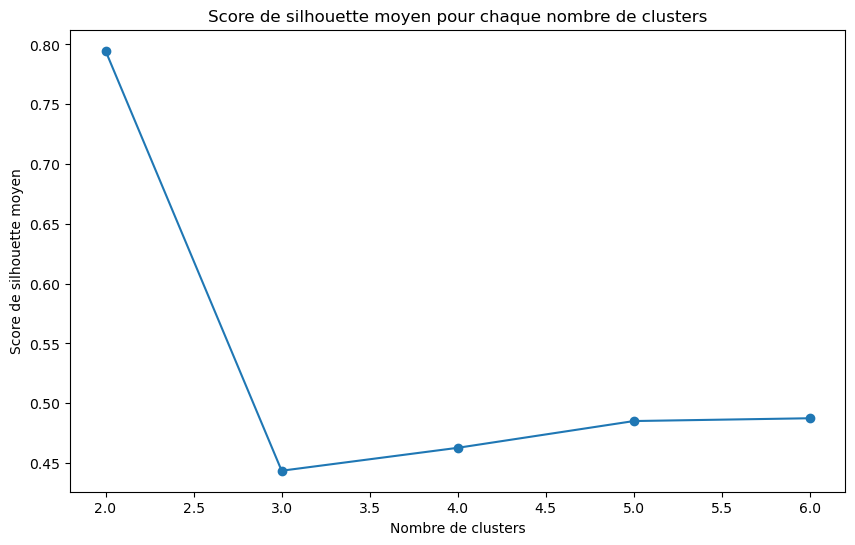

In [13]:
# Score de silhouette
fig = silhouette_coeff(6,X_scaled)
fig.savefig('silhouette_1.png', dpi=300)

In [14]:
# Calculer le score de silhouette pour chaque nombre de cluster
range_n_clusters = list(range(2,7))
print ("Number of clusters from 2 to 6: \n", range_n_clusters)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters).fit(X_scaled)
    preds = clusterer.predict(X_scaled)
    centers = clusterer.cluster_centers_
    score = round((silhouette_score(X_scaled, preds, metric='euclidean')),3)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

Number of clusters from 2 to 6: 
 [2, 3, 4, 5, 6]
For n_clusters = 2, silhouette score is 0.795)
For n_clusters = 3, silhouette score is 0.446)
For n_clusters = 4, silhouette score is 0.449)
For n_clusters = 5, silhouette score is 0.472)
For n_clusters = 6, silhouette score is 0.501)


Le nombre optimal selon le silhouette score est de 2 clusters, mais ca ne
sera pas très interessant au vu des outliers présent dans le dataset. 
Nous prenons le score le deuxième score le plus élevé, qui représente 6 clusters.

In [15]:
# Demander à l'utilisateur de choisir le nombre de clusters
num_clusters = 6

# Effectuer la CAH avec le nombre de clusters choisi
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Ajouter les informations de cluster dans le DataFrame
bilan_pop_2017['Cluster'] = clusters
X['Cluster'] = clusters

# Afficher les statistiques des clusters
cluster_stats = bilan_pop_2017.groupby('Cluster').mean()
cluster_stats = cluster_stats.drop(['Code zone'], axis=1)
cluster_stats

,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab)
Cluster,,,,,,,,
1,2.664593e+08,51.245000,14103.500000,3957.500000,63.000000,14021.000000,18041.000000,67.789980
2,1.421022e+09,12.730000,17621.000000,576.000000,452.000000,17957.000000,18405.000000,12.951948
3,3.457158e+07,11.793559,225.838983,10.330508,46.881356,222.169492,204.110169,7.896628
4,7.367890e+07,31.276667,2004.500000,289.833333,899.833333,1986.333333,1563.500000,18.147537
5,6.136334e+05,51.065000,28.785714,0.285714,25.000000,27.714286,5.500000,5.584148
6,2.657847e+07,34.389211,863.105263,168.289474,93.394737,838.710526,946.973684,41.360227


In [16]:
# Créer un boxplot pour chaque colonne numérique
def boxplot_1 (data, var) :
    num_cols = len(data.columns) # -1 pour exclure 'status_type'

    # Nombre de lignes pour les sous-graphiques
    num_rows = num_cols // 2
    if num_cols % 2:
        num_rows += 1

    fig = plt.figure(figsize=(10, 4 * num_rows))
    for i, column in enumerate(data.columns, start=1):
        plt.subplot(num_rows, 2, i)
        sns.boxplot(x=var, y=column, data=data)
        plt.title(column)

    plt.tight_layout()
    plt.show()
    
    return fig

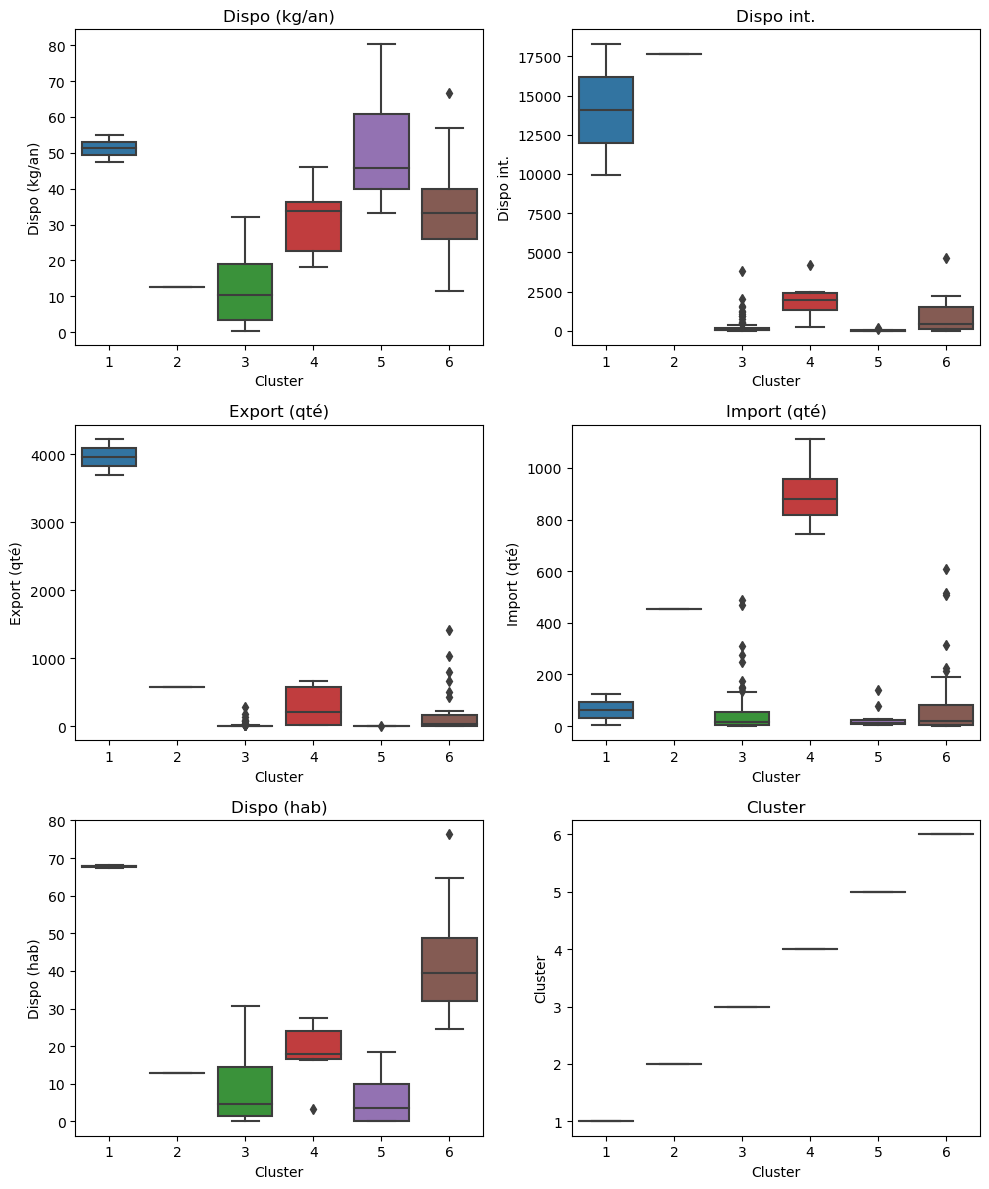

In [17]:
# Représenter la composition des clusters par des Boxplot par variables
fig = boxplot_1(X, X.Cluster)
fig.savefig('boxplot_1.png', dpi=300)

D'après ces résultats, on sait que nous écarterons les pays du cluster 1 de notre analyse si on poursuit avec ces clusters.

In [18]:
# Afficher le contenu de chaque cluster
for i in range(1, 7) : 
    sub_df = bilan_pop_2017.loc[bilan_pop_2017.Cluster == i]

    print(f"cluster : {i}")

    zone_list = sub_df.Zone.values

    txt = [f"{n}" for n in zone_list]

    txt = " / ".join(txt)

    print(txt)
    print("\n")

cluster : 1
Brésil / États-Unis d'Amérique


cluster : 2
Chine, continentale


cluster : 3
Afghanistan / Albanie / Algérie / Angola / Arménie / Autriche / Azerbaïdjan / Bangladesh / Bénin / Bosnie-Herzégovine / Botswana / Bulgarie / Burkina Faso / Burundi / Cabo Verde / Cambodge / Cameroun / Chypre / Comores / Congo / Côte d'Ivoire / Croatie / Cuba / Danemark / Djibouti / Égypte / El Salvador / Émirats arabes unis / Équateur / Estonie / Eswatini / Éthiopie / Finlande / Gambie / Géorgie / Ghana / Grèce / Guatemala / Guinée / Guinée-Bissau / Haïti / Honduras / Îles Salomon / Inde / Indonésie / Iraq / Irlande / Italie / Jordanie / Kazakhstan / Kenya / Kirghizistan / Kiribati / Lesotho / Lettonie / Liban / Libéria / Libye / Luxembourg / Macédoine du Nord / Madagascar / Malawi / Maldives / Mali / Malte / Maroc / Mauritanie / Mongolie / Monténégro / Mozambique / Namibie / Népal / Nicaragua / Niger / Nigéria / Norvège / Oman / Ouganda / Ouzbékistan / Pakistan / Papouasie-Nouvelle-Guinée / Par

In [19]:
# Homogénéité et variance des clusters
from sklearn.metrics.cluster import homogeneity_score
kmeans = KMeans(n_clusters=6, random_state=50)
y1_pred = kmeans.fit_predict(X_scaled)
y1_true = X.Cluster

hom_1 = round(homogeneity_score(y1_true, y1_pred),3)
print("Homogeneity score:", hom_1)

from sklearn.metrics.cluster import calinski_harabasz_score
cal_1 = round(calinski_harabasz_score(X_scaled, clusters),3)
print("Calinski Harabasz Score :", cal_1)

print("\nLa variance et l'homogénéité des clusters sont très bons, toutefois le cluster 3 regroupe à la "
      "fois des pays en voie de développement et des pays développé. "
      "On peut encore affiner l'analyse en choisissant d'autres indicateurs.")

Homogeneity score: 0.828
Calinski Harabasz Score : 116.382

La variance et l'homogénéité des clusters sont très bons, toutefois le cluster 3 regroupe à la fois des pays en voie de développement et des pays développé. On peut encore affiner l'analyse en choisissant d'autres indicateurs.


<div style="background-color: RGB(217, 117, 26);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">II - Enrichir l'analyse et affiner les clusters avec d'autres indicateurs FAO</h2>
</div>

<div style=" background-color: RGB(217, 146, 26);" >
<div style="border: 1px solid RGB(217, 146, 26);" >
<h3 style="margin: auto; padding: 20px; color: #fff"> II.I - Fichier 1</h3>
</div>

In [20]:
# Importation du fichier téléchargé en Opendata sur FAO
FAO = pd.read_csv('FAO_indicateurs.csv', sep=",")
FAO = pd.DataFrame(FAO)

# Visualiser les différentes unités et les données manquantes
print(FAO.Unité.value_counts())
print(FAO.isna().sum())

millions No    816
indice         196
I$             188
Name: Unité, dtype: int64
Code Domaine                0
Domaine                     0
Code zone (FAO)             0
Zone                        0
Code Élément                0
Élément                     0
Code Produit                0
Produit                     0
Code année                  0
Année                       0
Unité                       0
Valeur                    344
Symbole                     0
Description du Symbole      0
Note                      845
dtype: int64


In [21]:
# Repérer le nombre de valeurs manquantes et/ou supprimées
FAO['Description du Symbole'].value_counts()

Ciffre de sources internationales    384
Chiffre officiel                     355
Valeur manquante                     211
Valeur manquante; supprimée          133
Valeur estimée                       117
Name: Description du Symbole, dtype: int64

In [22]:
# Renommer les produits 
FAO["Produit"] = FAO["Produit"].map(
    {"PIB par habitant, ($ PPA internationaux constants de 2017)": "PIB PPA hab($)", 
     "Nombre de personnes sous-alimentées (millions) (moyenne sur 3 ans)": "Personnes sous alimentées (millions)",
     "Nombre de personnes en situation d’insécurité alimentaire modérée ou grave (millions) (moyenne sur 3 ans)"
     : "Personnes en insécurité modérée ou grave (millions)",
    "Stabilité politique et absence de violence/terrorisme (indice)":"Stabilité politique (indice)"},
    na_action='ignore')
FAO.sort_values(by='Valeur')

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
471,FS,Données de la sécurité alimentaire,91,Guyana,6125,Valeur,21032,Stabilité politique (indice),2017,2017,indice,-0.04,X,Ciffre de sources internationales,NaN
1018,FS,Données de la sécurité alimentaire,197,Sierra Leone,6125,Valeur,21032,Stabilité politique (indice),2017,2017,indice,-0.04,X,Ciffre de sources internationales,NaN
118,FS,Données de la sécurité alimentaire,57,Bélarus,6125,Valeur,21032,Stabilité politique (indice),2017,2017,indice,-0.05,X,Ciffre de sources internationales,NaN
601,FS,Données de la sécurité alimentaire,118,Koweït,6125,Valeur,21032,Stabilité politique (indice),2017,2017,indice,-0.05,X,Ciffre de sources internationales,NaN
1000,FS,Données de la sécurité alimentaire,195,Sénégal,6125,Valeur,21032,Stabilité politique (indice),2017,2017,indice,-0.05,X,Ciffre de sources internationales,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,FS,Données de la sécurité alimentaire,155,Vanuatu,6132,Valeur,210081M,NaN,20162018,2016-2018,millions No,NaN,O,Valeur manquante,NaN
1170,FS,Données de la sécurité alimentaire,155,Vanuatu,6132,Valeur,210081F,NaN,20162018,2016-2018,millions No,NaN,O,Valeur manquante,NaN
1173,FS,Données de la sécurité alimentaire,236,Venezuela (République bolivarienne du),6132,Valeur,210081,Personnes en insécurité modérée ou grave (mill...,20162018,2016-2018,millions No,NaN,Q,Valeur manquante; supprimée,NaN
1174,FS,Données de la sécurité alimentaire,236,Venezuela (République bolivarienne du),6132,Valeur,210081M,NaN,20162018,2016-2018,millions No,NaN,Q,Valeur manquante; supprimée,NaN


In [23]:
# Contrôler nombre et localisation des données manquantes
manquants(FAO)

Code Domaine                0
Domaine                     0
Code zone (FAO)             0
Zone                        0
Code Élément                0
Élément                     0
Code Produit                0
Produit                   408
Code année                  0
Année                       0
Unité                       0
Valeur                    344
Symbole                     0
Description du Symbole      0
Note                      845
dtype: int64

In [24]:
# Renommer colonne
FAO = FAO.rename(columns={'Code zone (FAO)': 'Code zone'})

# Conserver les colonnes pertinentes à l'analyse
FAO = FAO[['Code zone','Zone','Produit','Année', 'Valeur']]
FAO

,Code zone,Zone,Produit,Année,Valeur
0,150,Pays-Bas (Royaume des),PIB PPA hab($),2017,55088.6
1,150,Pays-Bas (Royaume des),Personnes sous alimentées (millions),2016-2018,NaN
2,150,Pays-Bas (Royaume des),Personnes en insécurité modérée ou grave (mill...,2016-2018,0.9
3,150,Pays-Bas (Royaume des),NaN,2016-2018,0.3
4,150,Pays-Bas (Royaume des),NaN,2016-2018,0.5
...,...,...,...,...,...
1195,181,Zimbabwe,Personnes sous alimentées (millions),2016-2018,5.4
1196,181,Zimbabwe,Personnes en insécurité modérée ou grave (mill...,2016-2018,9.9
1197,181,Zimbabwe,NaN,2016-2018,2.5
1198,181,Zimbabwe,NaN,2016-2018,3.2


In [25]:
# Remplacer valeurs
FAO = FAO.replace(["Pays-Bas (Royaume des)"], "Pays-Bas")
print(FAO.Valeur.value_counts())
FAO = FAO.replace(["<0.1"], "0.099")
FAO

<0.1       60
0.2        33
0.3        31
0.1        26
0.4        25
           ..
47570.1     1
12822       1
11.5        1
25926.4     1
-0.71       1
Name: Valeur, Length: 448, dtype: int64


,Code zone,Zone,Produit,Année,Valeur
0,150,Pays-Bas,PIB PPA hab($),2017,55088.6
1,150,Pays-Bas,Personnes sous alimentées (millions),2016-2018,NaN
2,150,Pays-Bas,Personnes en insécurité modérée ou grave (mill...,2016-2018,0.9
3,150,Pays-Bas,NaN,2016-2018,0.3
4,150,Pays-Bas,NaN,2016-2018,0.5
...,...,...,...,...,...
1195,181,Zimbabwe,Personnes sous alimentées (millions),2016-2018,5.4
1196,181,Zimbabwe,Personnes en insécurité modérée ou grave (mill...,2016-2018,9.9
1197,181,Zimbabwe,NaN,2016-2018,2.5
1198,181,Zimbabwe,NaN,2016-2018,3.2


In [26]:
# Faire pivoter le tableau
FAO_pivot = FAO.pivot_table(index = ['Code zone','Zone'], columns = ['Produit'], values = 'Valeur')
FAO_pivot

,Produit,PIB PPA hab($),Personnes en insécurité modérée ou grave (millions),Personnes sous alimentées (millions),Stabilité politique (indice)
Code zone,Zone,,,,
1,Arménie,12509.6,0.500,NaN,-0.62
2,Afghanistan,2096.1,19.300,8.1,-2.80
3,Albanie,12771.0,1.100,0.1,0.38
4,Algérie,11809.5,8.100,1.1,-0.92
5,Samoa américaines,NaN,NaN,NaN,1.22
...,...,...,...,...,...
273,Monténégro,19682.3,0.099,NaN,-0.06
276,Soudan,4614.0,18.900,4.5,-1.98
277,Soudan du Sud,NaN,9.100,NaN,-2.45


In [27]:
# Contrôler la proportion de manquants pour chaques indicateurs
liste_var = ['PIB PPA hab($)', 'Personnes en insécurité modérée ou grave (millions)',
               'Personnes sous alimentées (millions)','Stabilité politique (indice)']
    
missing_data(liste_var, FAO_pivot)
    
print('Les données liées à l\'insécurité et à la sous alimentation'
      ' ne sont pas exploitables car la proportion de données manquantes est trop élevée.')

PIB PPA hab($)  --- Proportion : 6.47 %
Personnes en insécurité modérée ou grave (millions)  --- Proportion : 40.8 %
Personnes sous alimentées (millions)  --- Proportion : 41.79 %
Stabilité politique (indice)  --- Proportion : 2.49 %
Les données liées à l'insécurité et à la sous alimentation ne sont pas exploitables car la proportion de données manquantes est trop élevée.


In [28]:
# Visualiser les données manquantes de la varible personnes en insécurité alimentaire 
FAO_pivot[FAO_pivot['Personnes en insécurité modérée ou grave (millions)'].isna()]

,Produit,PIB PPA hab($),Personnes en insécurité modérée ou grave (millions),Personnes sous alimentées (millions),Stabilité politique (indice)
Code zone,Zone,,,,
5,Samoa américaines,NaN,NaN,NaN,1.22
6,Andorre,NaN,NaN,NaN,1.42
7,Angola,7216.1,NaN,4.4,-0.38
8,Antigua-et-Barbuda,20777.9,NaN,NaN,0.75
12,Bahamas,34357.3,NaN,NaN,0.99
...,...,...,...,...,...
227,Tuvalu,4208.9,NaN,NaN,1.24
236,Venezuela (République bolivarienne du),NaN,NaN,7.0,-1.27
250,République démocratique du Congo,1023.5,NaN,26.3,-2.30


In [29]:
# Visualiser les données manquantes de la varible personnes sous alimentées
FAO_pivot[FAO_pivot['Personnes sous alimentées (millions)'].isna()]

,Produit,PIB PPA hab($),Personnes en insécurité modérée ou grave (millions),Personnes sous alimentées (millions),Stabilité politique (indice)
Code zone,Zone,,,,
1,Arménie,12509.6,0.500,NaN,-0.62
5,Samoa américaines,NaN,NaN,NaN,1.22
6,Andorre,NaN,NaN,NaN,1.42
8,Antigua-et-Barbuda,20777.9,NaN,NaN,0.75
10,Australie,48400.2,3.100,NaN,0.90
...,...,...,...,...,...
272,Serbie,16611.0,1.100,NaN,0.09
273,Monténégro,19682.3,0.099,NaN,-0.06
277,Soudan du Sud,NaN,9.100,NaN,-2.45


Je n'ai aucune explication quant au volume des données manquantes des deux variables ci-dessus, 
je décide donc de les écarter de mon dataset.

In [30]:
# Supprimer les colonnes pour lesquelles il n'y a ni logique, ni un jeu de données suffisamment conséquent pour analyse
FAO_pivot = FAO_pivot.drop(['Personnes en insécurité modérée ou grave (millions)', 
                            'Personnes sous alimentées (millions)'], axis=1)

In [31]:
# Jointure entre bilan pop et nouveau pivot table pour ajout des indicateurs au df
bilan_fao = pd.merge(bilan_pop_2017, FAO_pivot,
                      how="outer",
                      on=('Code zone','Zone'), indicator=True)

print(bilan_fao._merge.value_counts())
bilan_fao.head()

both          179
right_only     22
left_only       0
Name: _merge, dtype: int64


,Code zone,Zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),_merge
0,2,Afghanistan,36296113.0,1.79,64.0,0.0,29.0,64.0,28.0,0.771432,3.0,2096.1,-2.80,both
1,202,Afrique du Sud,57009756.0,37.25,2110.0,63.0,514.0,2110.0,1665.0,29.205528,6.0,13950.5,-0.28,both
2,3,Albanie,2884169.0,11.55,33.0,0.0,20.0,33.0,13.0,4.507364,3.0,12771.0,0.38,both
3,4,Algérie,41389189.0,6.95,286.0,0.0,2.0,286.0,284.0,6.861695,3.0,11809.5,-0.92,both
4,79,Allemagne,82658409.0,18.06,1557.0,646.0,842.0,1492.0,1514.0,18.316346,4.0,53071.5,0.59,both


In [32]:
# Consulter les données non présentes dans le df de base
bilan_fao.loc[bilan_fao["_merge"] == "right_only"].head()

,Code zone,Zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),_merge
179,5,Samoa américaines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.22,right_only
180,6,Andorre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.42,right_only
181,13,Bahreïn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48929.4,-0.96,right_only
182,17,Bermudes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81835.0,1.00,right_only
183,18,Bhoutan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10986.9,1.12,right_only


In [33]:
print('Il s\'agit des pays écartés plus tôt car nous n\'avions pas d\'infos.')

Il s'agit des pays écartés plus tôt car nous n'avions pas d'infos.


In [34]:
# Ne garder que les both
bilan_fao = bilan_fao.loc[bilan_fao["_merge"] == "both"]
bilan_fao.head()

,Code zone,Zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),_merge
0,2,Afghanistan,36296113.0,1.79,64.0,0.0,29.0,64.0,28.0,0.771432,3.0,2096.1,-2.80,both
1,202,Afrique du Sud,57009756.0,37.25,2110.0,63.0,514.0,2110.0,1665.0,29.205528,6.0,13950.5,-0.28,both
2,3,Albanie,2884169.0,11.55,33.0,0.0,20.0,33.0,13.0,4.507364,3.0,12771.0,0.38,both
3,4,Algérie,41389189.0,6.95,286.0,0.0,2.0,286.0,284.0,6.861695,3.0,11809.5,-0.92,both
4,79,Allemagne,82658409.0,18.06,1557.0,646.0,842.0,1492.0,1514.0,18.316346,4.0,53071.5,0.59,both


In [35]:
# Reperer les données manquantes
manquants(bilan_fao)

Code zone                       0
Zone                            0
Population                      0
Dispo (kg/an)                   0
Dispo int.                      0
Export (qté)                    0
Import (qté)                    0
Nourriture                      0
Production                      0
Dispo (hab)                     0
Cluster                         0
PIB PPA hab($)                  8
Stabilité politique (indice)    4
_merge                          0
dtype: int64

In [36]:
# Visualiser les données manquantes de la variable Stabilité politique
bilan_fao[bilan_fao['Stabilité politique (indice)'].isna()]

,Code zone,Zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),_merge
34,41,"Chine, continentale",1.421022e+09,12.73,17621.0,576.0,452.0,17957.0,18405.0,12.951948,2.0,14243.5,NaN,both
35,214,"Chine, Taiwan Province de",2.367455e+07,33.44,792.0,8.0,161.0,791.0,657.0,27.751324,6.0,NaN,NaN,both
118,153,Nouvelle-Calédonie,2.771500e+05,36.01,10.0,0.0,10.0,10.0,1.0,3.608154,5.0,NaN,NaN,both
131,70,Polynésie française,2.761020e+05,45.75,16.0,0.0,15.0,14.0,1.0,3.621850,5.0,NaN,NaN,both


In [37]:
# Remplacer les manquants de la variable stabilité politique
bilan_fao.iat[34, 12] = -0.230
bilan_fao.iat[35, 12] = 0.860
bilan_fao.iat[118, 12] = 0.280
bilan_fao.iat[131, 12] = 0.280

In [38]:
# Visualiser les données manquantes de la variable PIB PPA
bilan_fao[bilan_fao['PIB PPA hab($)'].isna()]

,Code zone,Zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),_merge
35,214,"Chine, Taiwan Province de",23674546.0,33.44,792.0,8.0,161.0,791.0,657.0,27.751324,6.0,NaN,0.86,both
43,49,Cuba,11339254.0,28.51,326.0,0.0,312.0,323.0,29.0,2.557487,3.0,NaN,0.65,both
118,153,Nouvelle-Calédonie,277150.0,36.01,10.0,0.0,10.0,10.0,1.0,3.608154,5.0,NaN,0.28,both
131,70,Polynésie française,276102.0,45.75,16.0,0.0,15.0,14.0,1.0,3.621850,5.0,NaN,0.28,both
133,212,République arabe syrienne,17095678.0,8.16,155.0,0.0,33.0,155.0,122.0,7.136307,3.0,NaN,-2.62,both
140,116,République populaire démocratique de Corée,25429825.0,1.68,43.0,0.0,0.0,43.0,43.0,1.690928,3.0,NaN,-0.50,both
174,236,Venezuela (République bolivarienne du),29402484.0,15.89,486.0,0.0,23.0,486.0,462.0,15.712958,3.0,NaN,-1.27,both
176,249,Yémen,27834819.0,8.41,253.0,0.0,82.0,253.0,171.0,6.143385,3.0,NaN,-2.94,both


In [39]:
# Remplacer les manquants de la variable PIB PPA, 
# source https://fr.wikipedia.org/wiki/Liste_des_pays_par_PIB_(PPA)_par_habitant
bilan_fao.iat[35, 11] = 24408
bilan_fao.iat[43, 11] = 11900
bilan_fao.iat[118, 11] = 31100
bilan_fao.iat[131, 11] = 17000
bilan_fao.iat[133, 11] = 2900
bilan_fao.iat[140, 11] = 1700
bilan_fao.iat[174, 11] = 12400
bilan_fao.iat[176, 11] = 2300

In [40]:
# Contrôle des mannquants
manquants(bilan_fao)

Code zone                       0
Zone                            0
Population                      0
Dispo (kg/an)                   0
Dispo int.                      0
Export (qté)                    0
Import (qté)                    0
Nourriture                      0
Production                      0
Dispo (hab)                     0
Cluster                         0
PIB PPA hab($)                  0
Stabilité politique (indice)    0
_merge                          0
dtype: int64

In [41]:
# Conserver les colonnes pertinentes à l'analyse
bilan_fao = bilan_fao.drop(['_merge'], axis=1)

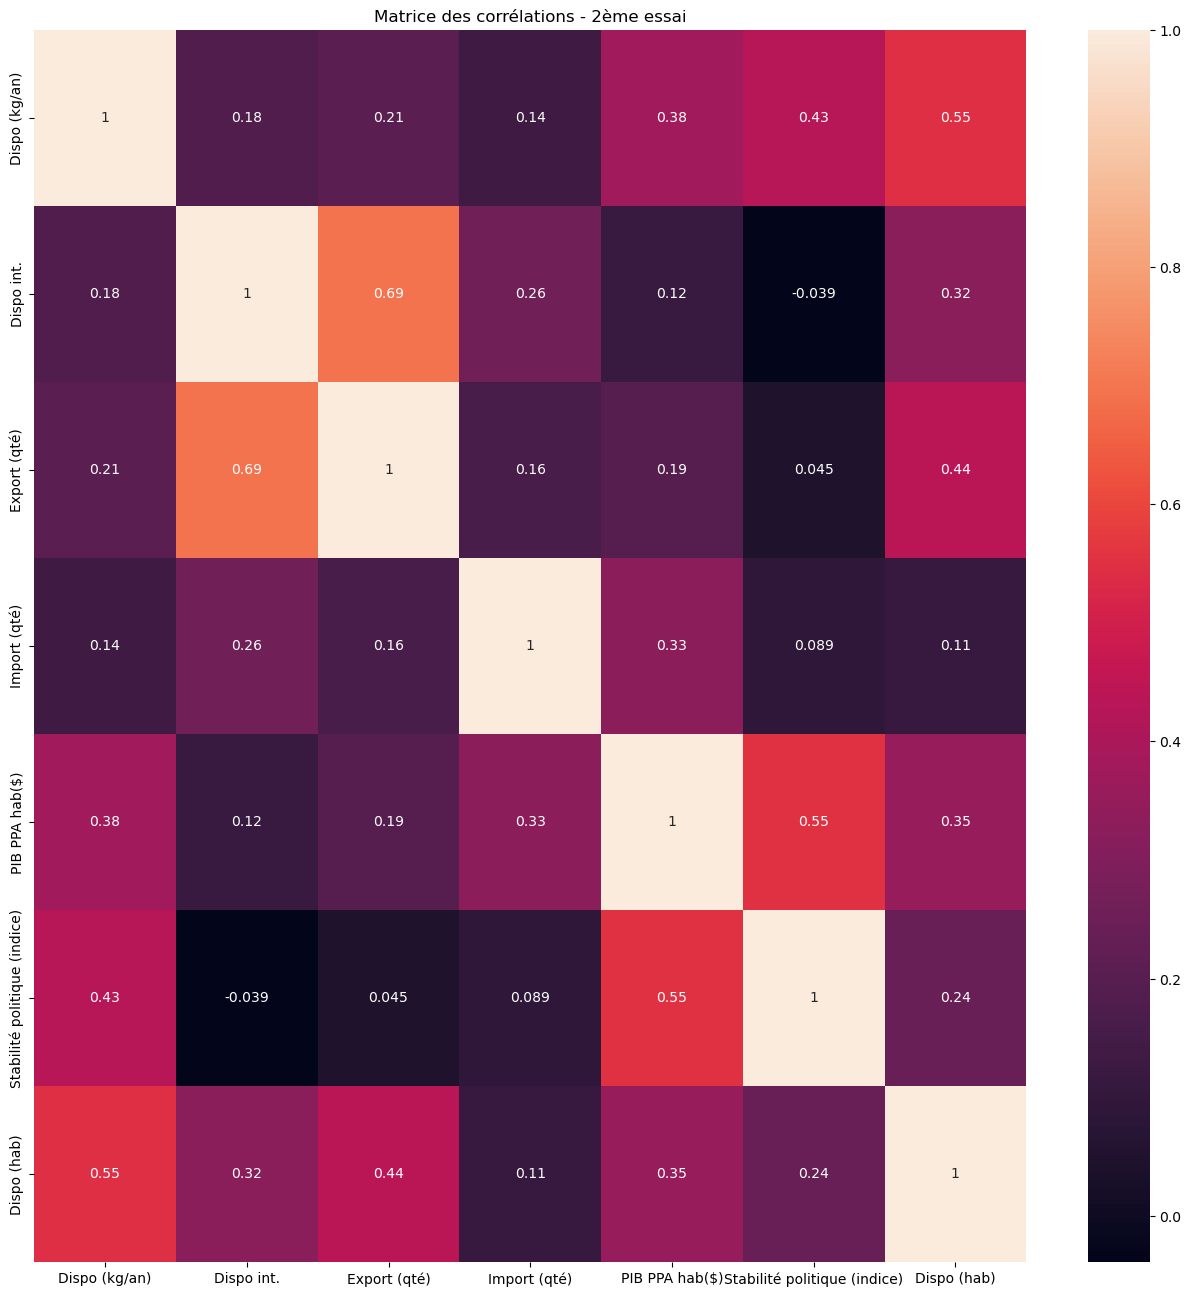

In [42]:
# Matrice des corrélations en vue de définir les variables pertinentes à la suite de l'analyse
join_var = bilan_fao[['Dispo (kg/an)','Dispo int.', 'Export (qté)','Import (qté)',
                      'PIB PPA hab($)','Stabilité politique (indice)','Dispo (hab)']]

corr_join = join_var.corr(method="pearson")

# Visualiser la matrice
fig = plt.figure(figsize=(16, 16))
sns.heatmap(corr_join, annot=True)
plt.title('Matrice des corrélations - 2ème essai')
plt.show()
fig.savefig('matrice_corr_2.png')

Les nouveaux indicateurs sont corrélés entre eux et avec la dispo anuuelle en kg. 
Nous gardons donc ces deux indicateurs pour la suite de l'analyse.

<div style=" background-color: RGB(217, 146, 26);" >
<div style="border: 1px solid RGB(217, 146, 26);" >
<h3 style="margin: auto; padding: 20px; color: #fff"> II.II - Fichier 2</h3>
</div>

In [43]:
# Importation du fichier téléchargé en Opendata sur FAO
FAO_1 = pd.read_csv('FAO_indicateurs_2.csv', sep=",")
FAO_1 = pd.DataFrame(FAO_1)

# Visualiser les différentes unités et les données manquantes
print(FAO_1.Unité.value_counts())
print(FAO_1.isna().sum())

%                 573
Millions d’USD    287
Name: Unité, dtype: int64
Code Domaine                0
Domaine                     0
Code zone (FAO)             0
Zone                        0
Code Élément                0
Élément                     0
Code Produit                0
Produit                     0
Code année                  0
Année                       0
Unité                       0
Valeur                      0
Symbole                     0
Description du Symbole      0
Note                      860
dtype: int64


In [44]:
# Renommer colonne
FAO_1 = FAO_1.rename(columns={'Code zone (FAO)': 'Code zone'})
FAO_1.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,MK,Indicateurs macro,2,Afghanistan,6110,Valeur US $,22008,Produit Intérieur Brut,2017,2017,Millions d’USD,18896.352021,X,Ciffre de sources internationales,NaN
1,MK,Indicateurs macro,2,Afghanistan,6129,Croissance annuelle US$,22008,Produit Intérieur Brut,2017,2017,%,4.865789,X,Ciffre de sources internationales,NaN
2,MK,Indicateurs macro,2,Afghanistan,61290,Croissance annuelle US$ par habitant,22008,Produit Intérieur Brut,2017,2017,%,1.902494,X,Ciffre de sources internationales,NaN
3,MK,Indicateurs macro,202,Afrique du Sud,6110,Valeur US $,22008,Produit Intérieur Brut,2017,2017,Millions d’USD,380851.444101,X,Ciffre de sources internationales,NaN
4,MK,Indicateurs macro,202,Afrique du Sud,6129,Croissance annuelle US$,22008,Produit Intérieur Brut,2017,2017,%,17.703799,X,Ciffre de sources internationales,NaN


In [45]:
# Conserver les colonnes pertinentes à l'analyse
FAO_1 = FAO_1[['Code zone','Zone','Élément','Produit','Année','Unité','Valeur']]
FAO_1

,Code zone,Zone,Élément,Produit,Année,Unité,Valeur
0,2,Afghanistan,Valeur US $,Produit Intérieur Brut,2017,Millions d’USD,18896.352021
1,2,Afghanistan,Croissance annuelle US$,Produit Intérieur Brut,2017,%,4.865789
2,2,Afghanistan,Croissance annuelle US$ par habitant,Produit Intérieur Brut,2017,%,1.902494
3,202,Afrique du Sud,Valeur US $,Produit Intérieur Brut,2017,Millions d’USD,380851.444101
4,202,Afrique du Sud,Croissance annuelle US$,Produit Intérieur Brut,2017,%,17.703799
...,...,...,...,...,...,...,...
855,251,Zambie,Part du PIB US $,Valeur ajoutée (Agriculture),2017,%,2.832627
856,251,Zambie,Croissance annuelle US$,Valeur ajoutée (Agriculture),2017,%,-31.684954
857,181,Zimbabwe,Valeur US $,Produit Intérieur Brut,2017,Millions d’USD,22040.654699
858,181,Zimbabwe,Croissance annuelle US$,Produit Intérieur Brut,2017,%,7.260693


In [46]:
# Concatener les données pour les renommer correctement
FAO_1["Concat"] = FAO_1["Produit"] + FAO_1["Élément"] + FAO_1["Unité"]
FAO_1.head()

,Code zone,Zone,Élément,Produit,Année,Unité,Valeur,Concat
0,2,Afghanistan,Valeur US $,Produit Intérieur Brut,2017,Millions d’USD,18896.352021,Produit Intérieur BrutValeur US $Millions d’USD
1,2,Afghanistan,Croissance annuelle US$,Produit Intérieur Brut,2017,%,4.865789,Produit Intérieur BrutCroissance annuelle US$%
2,2,Afghanistan,Croissance annuelle US$ par habitant,Produit Intérieur Brut,2017,%,1.902494,Produit Intérieur BrutCroissance annuelle US$ ...
3,202,Afrique du Sud,Valeur US $,Produit Intérieur Brut,2017,Millions d’USD,380851.444101,Produit Intérieur BrutValeur US $Millions d’USD
4,202,Afrique du Sud,Croissance annuelle US$,Produit Intérieur Brut,2017,%,17.703799,Produit Intérieur BrutCroissance annuelle US$%


In [47]:
# Contrôler les manquants
FAO_1[FAO_1['Concat'].isna()]

,Code zone,Zone,Élément,Produit,Année,Unité,Valeur,Concat


In [48]:
# Visualiser les différents indicateurs/unités
FAO_1.Concat.value_counts()

Produit Intérieur BrutValeur US $Millions d’USD                211
Produit Intérieur BrutCroissance annuelle US$%                 211
Produit Intérieur BrutCroissance annuelle US$ par habitant%    211
Valeur ajoutée (Agriculture)Valeur US $Millions d’USD           76
Valeur ajoutée (Agriculture)Part du PIB US $%                   76
Valeur ajoutée (Agriculture)Croissance annuelle US$%            75
Name: Concat, dtype: int64

In [49]:
# Renommer les produits 
FAO_1["Produit"] = FAO_1["Concat"].map(
    {"Produit Intérieur BrutValeur US $Millions d’USD": "PIB ($)", 
     "Produit Intérieur BrutCroissance annuelle US$%": "PIB - Croissance (%)",
     "Produit Intérieur BrutCroissance annuelle US$ par habitant%": "PIB - Croissance par hab (%)",
     "Valeur ajoutée (Agriculture)Valeur US $Millions d’USD": "VA Agriculture ($)",
     "Valeur ajoutée (Agriculture)Part du PIB US $%": "VA Agriculture (Part PIB $)",
     "Valeur ajoutée (Agriculture)Croissance annuelle US$%": "VA Agriculture (Croissance %)"},
    na_action='ignore')
FAO_1 = FAO_1.replace(["Pays-Bas (Royaume des)"], "Pays-Bas")
FAO_1.head()

,Code zone,Zone,Élément,Produit,Année,Unité,Valeur,Concat
0,2,Afghanistan,Valeur US $,PIB ($),2017,Millions d’USD,18896.352021,Produit Intérieur BrutValeur US $Millions d’USD
1,2,Afghanistan,Croissance annuelle US$,PIB - Croissance (%),2017,%,4.865789,Produit Intérieur BrutCroissance annuelle US$%
2,2,Afghanistan,Croissance annuelle US$ par habitant,PIB - Croissance par hab (%),2017,%,1.902494,Produit Intérieur BrutCroissance annuelle US$ ...
3,202,Afrique du Sud,Valeur US $,PIB ($),2017,Millions d’USD,380851.444101,Produit Intérieur BrutValeur US $Millions d’USD
4,202,Afrique du Sud,Croissance annuelle US$,PIB - Croissance (%),2017,%,17.703799,Produit Intérieur BrutCroissance annuelle US$%


In [50]:
# Faire un tableau pivot
FAO_1_pivot = FAO_1.pivot_table(index = ['Code zone','Zone'], columns = ['Produit'], values = 'Valeur')

In [51]:
# Contrôle des manquants
manquants(FAO_1_pivot)

Produit
PIB ($)                            0
PIB - Croissance (%)               0
PIB - Croissance par hab (%)       0
VA Agriculture ($)               135
VA Agriculture (Croissance %)    136
VA Agriculture (Part PIB $)      135
dtype: int64

In [52]:
# Contrôler la proportion de manquants pour chaque indicateurs
liste_var = ['PIB ($)', 'PIB - Croissance (%)',
               'PIB - Croissance par hab (%)','VA Agriculture ($)',
            'VA Agriculture (Croissance %)','VA Agriculture (Part PIB $)']

missing_data(liste_var, FAO_1_pivot)

print('\nLes données liées à la valeur ajoutée agriculture'
      ' ne sont pas exploitables car la proportion de données manquantes est trop élevée.')

PIB ($)  --- Proportion : 0.0 %
PIB - Croissance (%)  --- Proportion : 0.0 %
PIB - Croissance par hab (%)  --- Proportion : 0.0 %
VA Agriculture ($)  --- Proportion : 63.98 %
VA Agriculture (Croissance %)  --- Proportion : 64.45 %
VA Agriculture (Part PIB $)  --- Proportion : 63.98 %

Les données liées à la valeur ajoutée agriculture ne sont pas exploitables car la proportion de données manquantes est trop élevée.


In [53]:
FAO_1_pivot[FAO_1_pivot['VA Agriculture ($)'].isna()]

,Produit,PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),VA Agriculture ($),VA Agriculture (Croissance %),VA Agriculture (Part PIB $)
Code zone,Zone,,,,,,
1,Arménie,1.152746e+04,9.305042,9.838244,NaN,NaN,NaN
2,Afghanistan,1.889635e+04,4.865789,1.902494,NaN,NaN,NaN
3,Albanie,1.301973e+04,9.765943,9.831055,NaN,NaN,NaN
4,Algérie,1.700970e+05,6.287892,4.228057,NaN,NaN,NaN
6,Andorre,3.000160e+03,3.645144,1.824543,NaN,NaN,NaN
...,...,...,...,...,...,...,...
277,Soudan du Sud,3.571365e+03,9.003176,13.174612,NaN,NaN,NaN
279,Curaçao,3.009497e+03,-0.174191,-0.631055,NaN,NaN,NaN
280,Sint Maarten (partie néerlandaise),1.289330e+03,-8.026143,-9.205380,NaN,NaN,NaN


In [54]:
FAO_1_pivot[FAO_1_pivot['VA Agriculture (Croissance %)'].isna()]

,Produit,PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),VA Agriculture ($),VA Agriculture (Croissance %),VA Agriculture (Part PIB $)
Code zone,Zone,,,,,,
1,Arménie,1.152746e+04,9.305042,9.838244,NaN,NaN,NaN
2,Afghanistan,1.889635e+04,4.865789,1.902494,NaN,NaN,NaN
3,Albanie,1.301973e+04,9.765943,9.831055,NaN,NaN,NaN
4,Algérie,1.700970e+05,6.287892,4.228057,NaN,NaN,NaN
6,Andorre,3.000160e+03,3.645144,1.824543,NaN,NaN,NaN
...,...,...,...,...,...,...,...
277,Soudan du Sud,3.571365e+03,9.003176,13.174612,NaN,NaN,NaN
279,Curaçao,3.009497e+03,-0.174191,-0.631055,NaN,NaN,NaN
280,Sint Maarten (partie néerlandaise),1.289330e+03,-8.026143,-9.205380,NaN,NaN,NaN


In [55]:
FAO_1_pivot[FAO_1_pivot['VA Agriculture (Part PIB $)'].isna()]

,Produit,PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),VA Agriculture ($),VA Agriculture (Croissance %),VA Agriculture (Part PIB $)
Code zone,Zone,,,,,,
1,Arménie,1.152746e+04,9.305042,9.838244,NaN,NaN,NaN
2,Afghanistan,1.889635e+04,4.865789,1.902494,NaN,NaN,NaN
3,Albanie,1.301973e+04,9.765943,9.831055,NaN,NaN,NaN
4,Algérie,1.700970e+05,6.287892,4.228057,NaN,NaN,NaN
6,Andorre,3.000160e+03,3.645144,1.824543,NaN,NaN,NaN
...,...,...,...,...,...,...,...
277,Soudan du Sud,3.571365e+03,9.003176,13.174612,NaN,NaN,NaN
279,Curaçao,3.009497e+03,-0.174191,-0.631055,NaN,NaN,NaN
280,Sint Maarten (partie néerlandaise),1.289330e+03,-8.026143,-9.205380,NaN,NaN,NaN


In [56]:
# Supprimer les indicateurs de VA Agriculture 
FAO_1_pivot = FAO_1_pivot.drop(['VA Agriculture ($)', 'VA Agriculture (Croissance %)',
                               'VA Agriculture (Part PIB $)'], axis=1)

In [57]:
# Contrôle des manquants
manquants(FAO_1_pivot)

Produit
PIB ($)                         0
PIB - Croissance (%)            0
PIB - Croissance par hab (%)    0
dtype: int64

In [58]:
# jointure entre précédent df et nouveaux indicateurs
bilan_fao_1 = pd.merge(bilan_fao, FAO_1_pivot,
                      how="outer",
                      on=('Code zone','Zone'), indicator=True)

print(bilan_fao_1._merge.value_counts())
bilan_fao_1

both          178
right_only     33
left_only       1
Name: _merge, dtype: int64


,Code zone,Zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),_merge
0,2,Afghanistan,36296113.0,1.79,64.0,0.0,29.0,64.0,28.0,0.771432,3.0,2096.1,-2.80,1.889635e+04,4.865789,1.902494,both
1,202,Afrique du Sud,57009756.0,37.25,2110.0,63.0,514.0,2110.0,1665.0,29.205528,6.0,13950.5,-0.28,3.808514e+05,17.703799,17.248839,both
2,3,Albanie,2884169.0,11.55,33.0,0.0,20.0,33.0,13.0,4.507364,3.0,12771.0,0.38,1.301973e+04,9.765943,9.831055,both
3,4,Algérie,41389189.0,6.95,286.0,0.0,2.0,286.0,284.0,6.861695,3.0,11809.5,-0.92,1.700970e+05,6.287892,4.228057,both
4,79,Allemagne,82658409.0,18.06,1557.0,646.0,842.0,1492.0,1514.0,18.316346,4.0,53071.5,0.59,3.690849e+06,6.441276,6.063881,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,277,Soudan du Sud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.571365e+03,9.003176,13.174612,right_only
208,279,Curaçao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.009497e+03,-0.174191,-0.631055,right_only
209,280,Sint Maarten (partie néerlandaise),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.289330e+03,-8.026143,-9.205380,right_only
210,299,Palestine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.612800e+04,4.690563,2.305457,right_only


In [59]:
# Voir les right
bilan_fao_1.loc[bilan_fao_1["_merge"] == "right_only"]

,Code zone,Zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),_merge
179,6,Andorre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000160e+03,3.645144,1.824543,right_only
180,13,Bahreïn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.547367e+04,10.046698,6.483332,right_only
181,17,Bermudes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.142316e+03,3.513146,3.174509,right_only
182,18,Bhoutan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.450366e+03,13.496635,12.541975,right_only
183,22,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.092430e+03,3.646331,3.090937,right_only
184,26,Brunéi Darussalam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.212817e+04,6.384935,5.326219,right_only
185,36,Îles Caïmanes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.166281e+03,5.234035,3.039349,right_only
186,47,Îles Cook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.456090e+02,11.537686,12.505906,right_only
187,61,Guinée équatoriale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.220091e+04,8.541141,4.667926,right_only
188,85,Groenland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.851613e+03,5.336778,5.314177,right_only


In [60]:
bilan_fao_1.loc[bilan_fao_1["_merge"] == "left_only"]

,Code zone,Zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),_merge
35,214,"Chine, Taiwan Province de",23674546.0,33.44,792.0,8.0,161.0,791.0,657.0,27.751324,6.0,24408.0,0.86,NaN,NaN,NaN,left_only


In [61]:
# Ajouter les données manquantes à Taiwan
bilan_fao_1.iat[35, 13] = 574900
bilan_fao_1.iat[35, 14] = 3.08
bilan_fao_1.iat[35, 15] = 6.5
bilan_fao_1.iat[35, 16] = "both"

In [62]:
# Ne garder que les both
bilan_fao_1 = bilan_fao_1.loc[bilan_fao_1["_merge"] == "both"]
bilan_fao_1 = bilan_fao_1.drop(["_merge"], axis=1)

In [63]:
# Contrôle des manquants
manquants(bilan_fao_1)

Code zone                       0
Zone                            0
Population                      0
Dispo (kg/an)                   0
Dispo int.                      0
Export (qté)                    0
Import (qté)                    0
Nourriture                      0
Production                      0
Dispo (hab)                     0
Cluster                         0
PIB PPA hab($)                  0
Stabilité politique (indice)    0
PIB ($)                         0
PIB - Croissance (%)            0
PIB - Croissance par hab (%)    0
dtype: int64

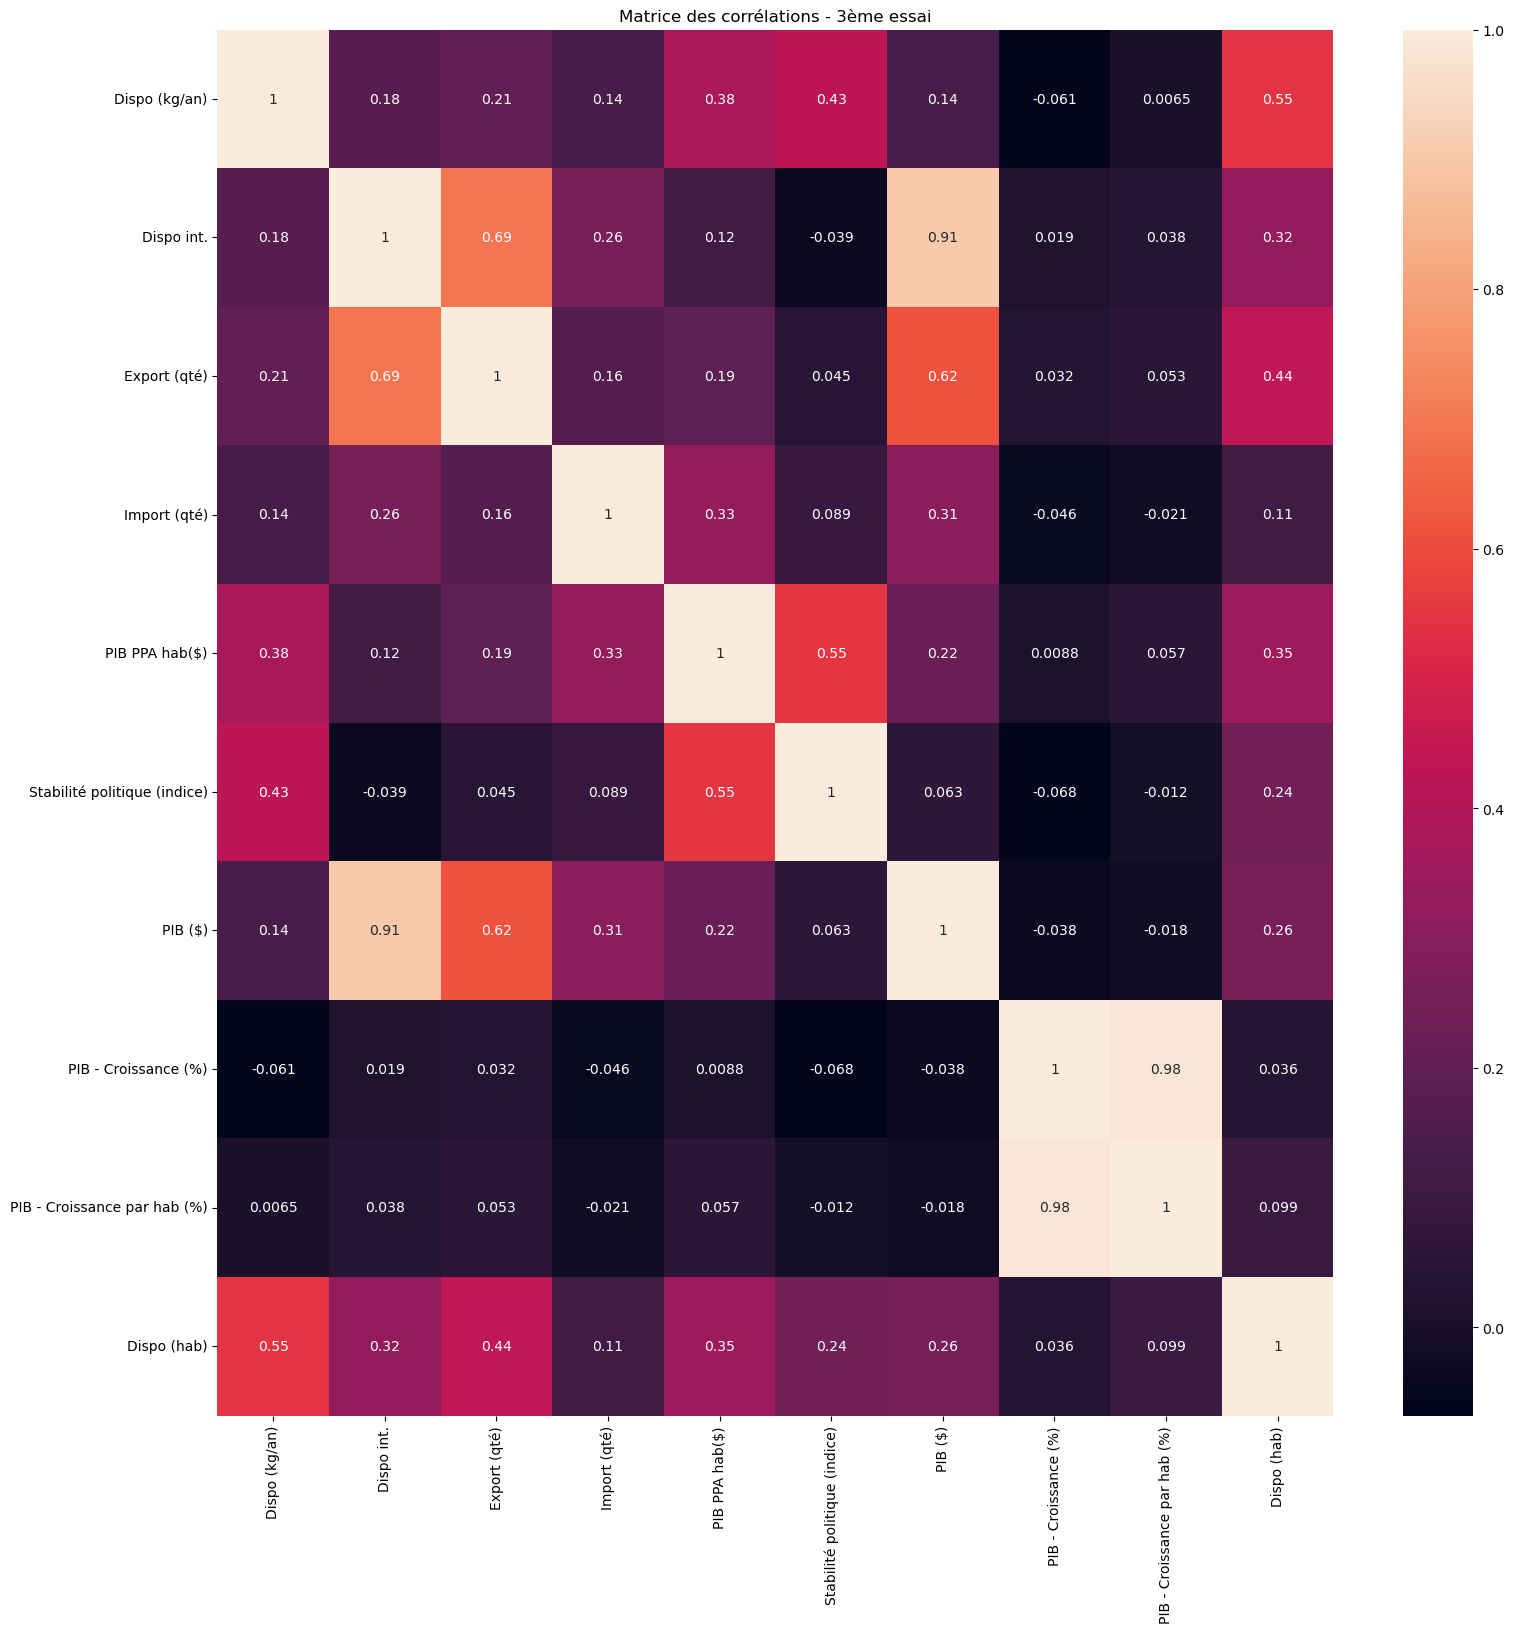

In [64]:
# Matrice des corrélations
join_var = bilan_fao_1[['Dispo (kg/an)','Dispo int.', 'Export (qté)','Import (qté)',
                        'PIB PPA hab($)','Stabilité politique (indice)','PIB ($)', 
                        'PIB - Croissance (%)','PIB - Croissance par hab (%)', 'Dispo (hab)']]

corr_join = join_var.corr(method="pearson")

# Visualiser la matrice
fig = plt.figure(figsize=(18, 18))
sns.heatmap(corr_join, annot=True)
plt.title('Matrice des corrélations - 3ème essai')
plt.show()
fig.savefig('Matrice_corr_3')

Nous ne garderons qu'une variable sur les deux portant sur le PIB en % puisqu'elles sont corrélées à 0.98.

<div style="background-color: RGB(217, 117, 26);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">III - Deuxième Classification Ascendante Hiérarchique</h2>
</div>

<div style=" background-color: RGB(217, 146, 26);" >
<div style="border: 1px solid RGB(217, 146, 26);" >
<h3 style="margin: auto; padding: 20px; color: #fff"> III.I - Définir X</h3>
</div>

In [65]:
# Stocker pays dans une variable
zone = bilan_fao_1.Zone.values
zone[:10]

array(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie'], dtype=object)

In [66]:
# Supprimer les colonnes avec du texte pour ne garder que les valeurs
X = bilan_fao_1[['Dispo (kg/an)','Dispo int.','Export (qté)',
                   'Import (qté)','PIB ($)', 'PIB PPA hab($)',
                   'Stabilité politique (indice)','PIB - Croissance (%)','Dispo (hab)']]
X[:3]

,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),PIB ($),PIB PPA hab($),Stabilité politique (indice),PIB - Croissance (%),Dispo (hab)
0,1.79,64.0,0.0,29.0,18896.352021,2096.1,-2.80,4.865789,0.771432
1,37.25,2110.0,63.0,514.0,380851.444101,13950.5,-0.28,17.703799,29.205528
2,11.55,33.0,0.0,20.0,13019.729856,12771.0,0.38,9.765943,4.507364


<div style=" background-color: RGB(217, 146, 26);" >
<div style="border: 1px solid RGB(217, 146, 26);" >
<h3 style="margin: auto; padding: 20px; color: #fff"> III.II - Normalisation des données</h3>
</div>

In [67]:
X_scaled = normalization(X)

#Contrôler que les données soient bien normalisées
pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]

,0,1,2,3,4,5,6,7,8
mean,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<div style=" background-color: RGB(217, 146, 26);" >
<div style="border: 1px solid RGB(217, 146, 26);" >
<h3 style="margin: auto; padding: 20px; color: #fff"> III.III - Calcul des distances entre les individus</h3>
</div>

In [68]:
# Calcul de la matrice de similarité/dissimilarité
linkage_matrix = linkage(X_scaled, method='ward', metric='euclidean')

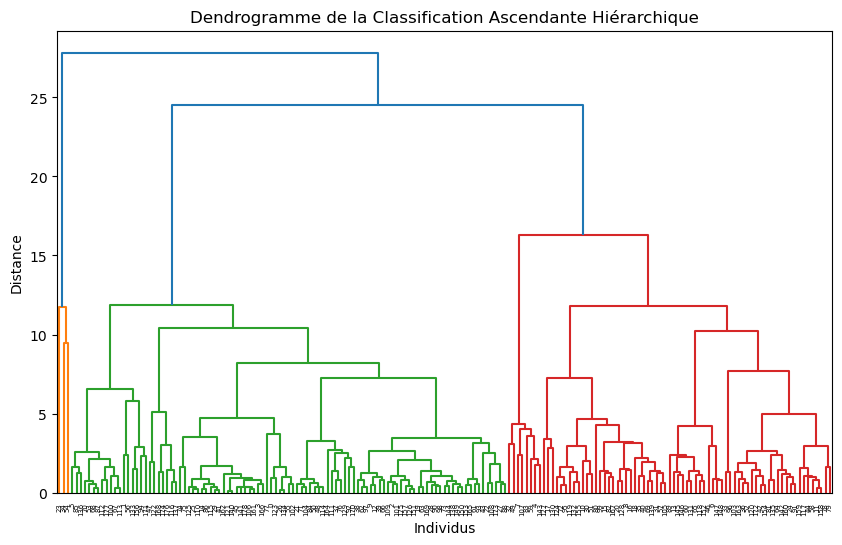

In [69]:
fig = dendrogram_viz(linkage_matrix)
fig.savefig('dendrogram_2.png', dpi=300)

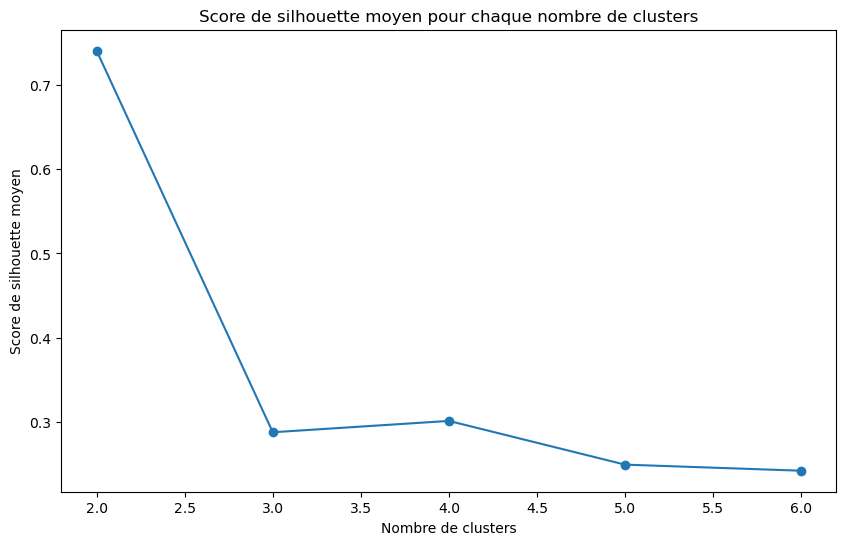

In [70]:
fig = silhouette_coeff(6,X_scaled)
fig.savefig('silhouette_2.png', dpi=300)

In [71]:
# Calcul du score de silouhette pour chaque cluster
range_n_clusters = list(range(2,7))
print ("Number of clusters from 2 to 6: \n", range_n_clusters)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters).fit(X_scaled)
    preds = clusterer.predict(X_scaled)
    centers = clusterer.cluster_centers_
    score = round(silhouette_score(X_scaled, preds, metric='euclidean'),3)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

Number of clusters from 2 to 6: 
 [2, 3, 4, 5, 6]
For n_clusters = 2, silhouette score is 0.741)
For n_clusters = 3, silhouette score is 0.295)
For n_clusters = 4, silhouette score is 0.308)
For n_clusters = 5, silhouette score is 0.306)
For n_clusters = 6, silhouette score is 0.284)


In [72]:
# Demander à l'utilisateur de choisir le nombre de clusters
num_clusters = 4

# Effectuer la CAH avec le nombre de clusters choisi
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Ajouter les informations de cluster dans le DataFrame
bilan_fao_1['Cluster_v2'] = clusters
X['Cluster_v2'] = clusters

# Afficher les statistiques des clusters
cluster_stats = bilan_fao_1.groupby('Cluster_v2').mean()
cluster_stats = cluster_stats.drop(['Code zone'], axis=1)
round(cluster_stats,2)

,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%)
Cluster_v2,,,,,,,,,,,,,,
1,6.513135e+08,38.41,15276.00,2830.33,192.67,15333.00,18162.33,49.51,1.33,29545.40,-0.14,11283781.21,9.56,8.77
2,4.330491e+07,10.92,362.64,18.04,43.33,360.56,349.69,7.45,3.21,7594.16,-0.64,125749.70,8.22,6.44
3,6.455039e+07,30.12,1784.38,284.00,796.75,1729.12,1398.50,17.74,4.12,47789.71,0.30,2059326.41,4.75,4.02
4,9.699888e+06,33.69,313.06,78.55,60.90,300.64,343.60,26.81,4.76,33947.01,0.64,262921.34,7.44,6.72


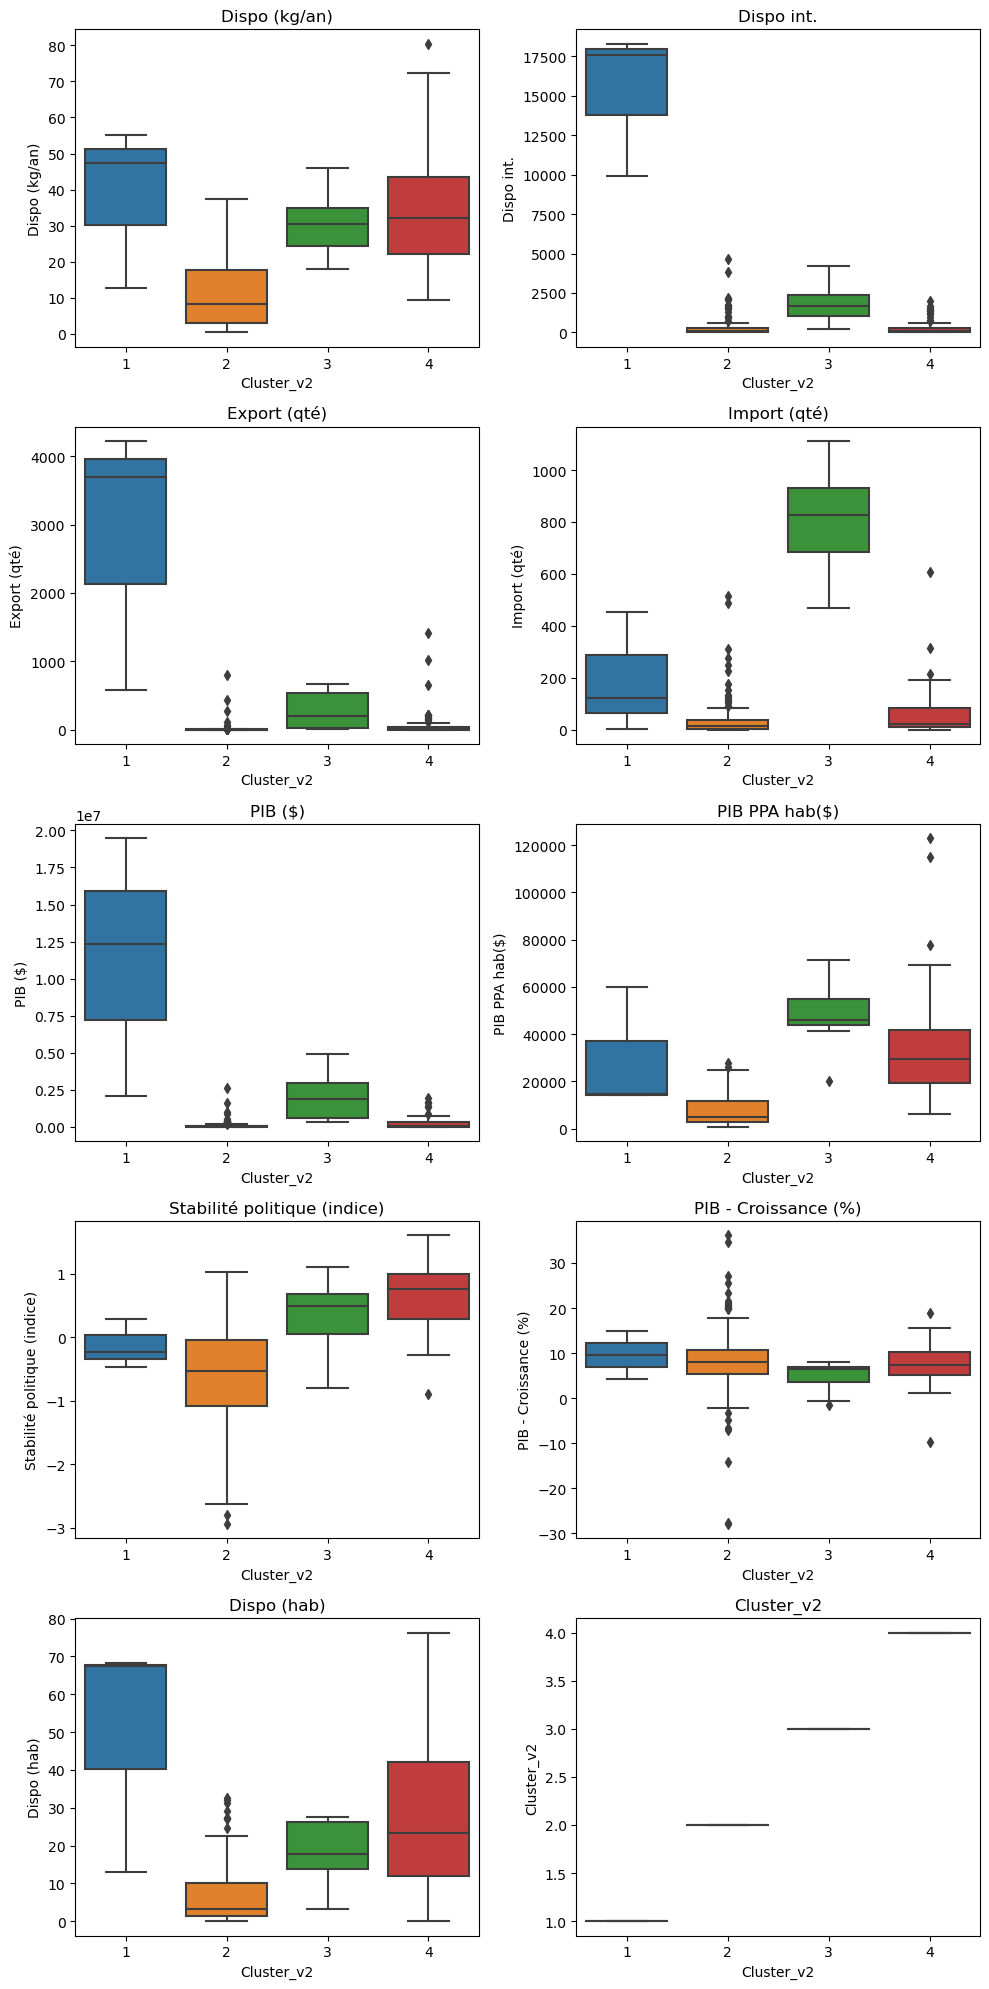

In [73]:
# Représenter la composition des clusters par des Boxplot par variables
fig = boxplot_1(X, X.Cluster_v2)
fig.savefig('boxplot_2.png', dpi=300)

In [74]:
# Afficher le contenu de chaque cluster
for i in range(1, 5) : 
    sub_df = bilan_fao_1.loc[bilan_fao_1.Cluster_v2 == i]

    print(f"cluster : {i}")

    zone_list = sub_df.Zone.values

    txt = [f"{n}" for n in zone_list]

    txt = " / ".join(txt)

    print(txt)
    print("\n")

cluster : 1
Brésil / Chine, continentale / États-Unis d'Amérique


cluster : 2
Afghanistan / Afrique du Sud / Albanie / Algérie / Angola / Arménie / Azerbaïdjan / Bangladesh / Bénin / Bosnie-Herzégovine / Botswana / Burkina Faso / Burundi / Cabo Verde / Cambodge / Cameroun / Colombie / Comores / Congo / Côte d'Ivoire / Cuba / Djibouti / Égypte / El Salvador / Équateur / Eswatini / Éthiopie / Fédération de Russie / Gambie / Géorgie / Ghana / Guatemala / Guinée / Guinée-Bissau / Haïti / Honduras / Îles Salomon / Inde / Indonésie / Iran (République islamique d') / Iraq / Jordanie / Kazakhstan / Kenya / Kirghizistan / Kiribati / Lesotho / Liban / Libéria / Libye / Macédoine du Nord / Madagascar / Malawi / Maldives / Mali / Maroc / Mauritanie / Mongolie / Monténégro / Mozambique / Myanmar / Namibie / Népal / Nicaragua / Niger / Nigéria / Ouganda / Ouzbékistan / Pakistan / Papouasie-Nouvelle-Guinée / Paraguay / Philippines / République arabe syrienne / République centrafricaine / République 

In [75]:
# Homogénéité et variance des clusters
kmeans = KMeans(n_clusters=4, random_state=50)
y1_pred = kmeans.fit_predict(X_scaled)
y1_true = X.Cluster_v2

hom_2 = round(homogeneity_score(y1_true, y1_pred),3)
print("Homogeneity score:", hom_2)

cal_2 = round(calinski_harabasz_score(X_scaled, clusters),3)
print("Calinski Harabasz Score :", cal_2)

print("\nLa variance est moins bonne qu'à l'essai précédent mais le score d'homogénéité a légèrement augmenté, "
      "et les clusters semblent être plus cohérents dans la classification. "
      "On effectue une ACP pour encore maximiser le résultat du clustering.")

Homogeneity score: 0.849
Calinski Harabasz Score : 60.608

La variance est moins bonne qu'à l'essai précédent mais le score d'homogénéité a légèrement augmenté, et les clusters semblent être plus cohérents dans la classification. On effectue une ACP pour encore maximiser le résultat du clustering.


<div style="background-color: RGB(217, 117, 26);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">IV - Analyse en Composantes Principales (ACP)
</div>

In [76]:
# Importer les libraires et charger seaborn
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection

On ajoute les variables "Nourriture" et "Production" qui sont fortement corrélées avec "Dispo intérieure". 
Le but de l'ACP étant une réduction des dimensions, nous pouvons les ajouter sans crainte de fausser les résultats. 

In [77]:
# Définir X
X = bilan_fao_1[['Dispo (kg/an)','Dispo int.','Export (qté)',
                   'Nourriture','Production','Import (qté)','PIB ($)', 'PIB PPA hab($)',
                   'Stabilité politique (indice)','PIB - Croissance (%)','Dispo (hab)']]
X[:5]

,Dispo (kg/an),Dispo int.,Export (qté),Nourriture,Production,Import (qté),PIB ($),PIB PPA hab($),Stabilité politique (indice),PIB - Croissance (%),Dispo (hab)
0,1.79,64.0,0.0,64.0,28.0,29.0,1.889635e+04,2096.1,-2.80,4.865789,0.771432
1,37.25,2110.0,63.0,2110.0,1665.0,514.0,3.808514e+05,13950.5,-0.28,17.703799,29.205528
2,11.55,33.0,0.0,33.0,13.0,20.0,1.301973e+04,12771.0,0.38,9.765943,4.507364
3,6.95,286.0,0.0,286.0,284.0,2.0,1.700970e+05,11809.5,-0.92,6.287892,6.861695
4,18.06,1557.0,646.0,1492.0,1514.0,842.0,3.690849e+06,53071.5,0.59,6.441276,18.316346


In [78]:
# Stocker variables 
zone = bilan_fao_1.Zone.values
variables = bilan_fao_1[['Dispo (kg/an)','Dispo int.','Export (qté)',
                   'Nourriture','Production','Import (qté)','PIB ($)', 'PIB PPA hab($)',
                   'Stabilité politique (indice)','PIB - Croissance (%)','Dispo (hab)']].columns

In [79]:
# Fitter, normaliser et contrôler les données
normalization(X)
X_scaled_pca = normalization(X)

# ACP
pca = PCA()
df_pca = pca.fit_transform(X_scaled_pca)

In [80]:
# On visualise les variances expliquées par composantes
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[4.81823259e+00 2.11029912e+00 1.07659552e+00 9.84543799e-01
 7.41869048e-01 5.20539628e-01 3.73563299e-01 3.26039864e-01
 1.08686924e-01 1.26124261e-03 1.66725868e-04]
[4.35574099e-01 1.90773612e-01 9.73255469e-02 8.90039595e-02
 6.70658662e-02 4.70574168e-02 3.37705775e-02 2.94744011e-02
 9.82543038e-03 1.14017869e-04 1.50722217e-05]


In [81]:
# Variance expliquée par composante et cumulé
composantes_var = pd.DataFrame({"Composante" : ["F" + str(x + 1) for x in range(11)], 
                   "Variance expliquée" : pca.explained_variance_,
                   "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
                   "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)})
composantes_var

,Composante,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,F1,4.818233,44.0,44.0
1,F2,2.110299,19.0,63.0
2,F3,1.076596,10.0,72.0
3,F4,0.984544,9.0,81.0
4,F5,0.741869,7.0,88.0
5,F6,0.520540,5.0,93.0
6,F7,0.373563,3.0,96.0
7,F8,0.326040,3.0,99.0
8,F9,0.108687,1.0,100.0
9,F10,0.001261,0.0,100.0


In [82]:
# On défini une variable avec la liste de nos composantes
n_components = 11
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

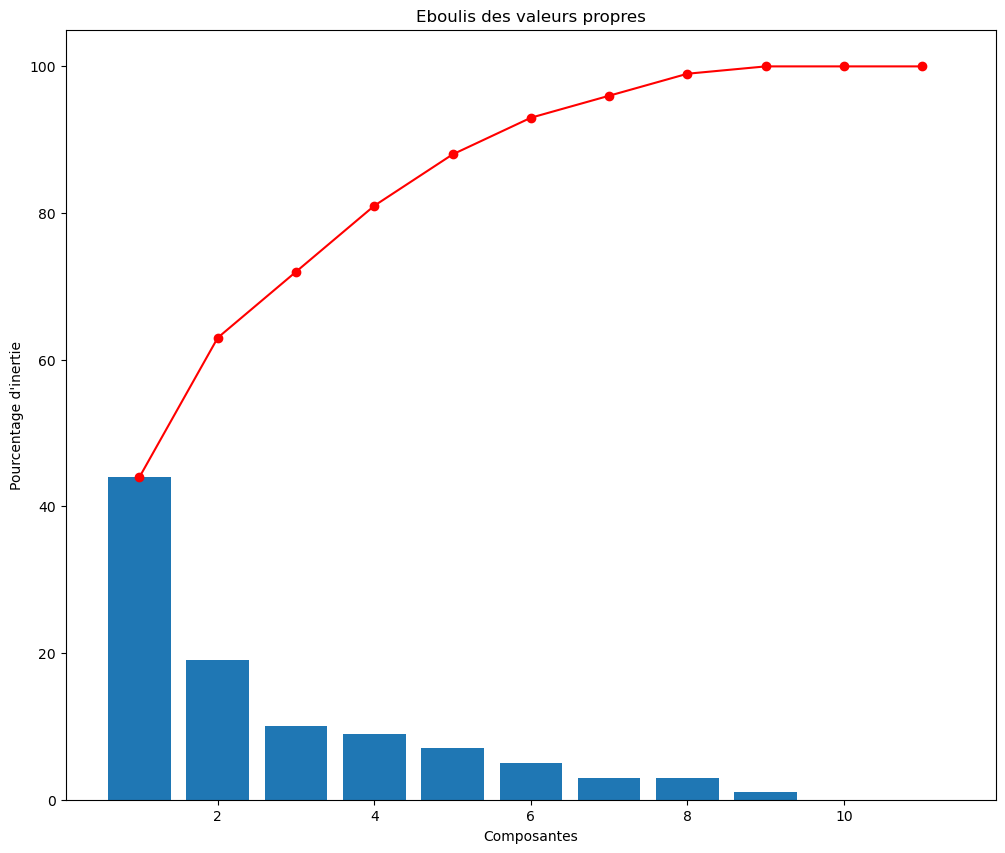

In [83]:
# Visualisation de l'éboulis
fig = plt.figure(figsize=(12, 10))
plt.bar(x_list, composantes_var['% variance expliquée'])
plt.plot(x_list, composantes_var['% cum. var. expliquée'],c="red",marker='o')
plt.xlabel("Composantes")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)
fig.savefig('Eboulis des valeurs propres.png')

On explique 81% de l'inertie avec 4 composantes.

In [84]:
# Visualiser les composantes dans un tableau
pcs = pca.components_
pcs = pd.DataFrame(pcs)

pcs.columns = variables
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

round(pcs.T,3)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
Dispo (kg/an),0.155,-0.473,-0.209,0.244,0.289,0.592,0.004,0.456,0.087,0.007,-0.001
Dispo int.,0.436,0.166,0.021,0.008,-0.062,0.151,-0.108,-0.060,-0.307,-0.342,0.727
Export (qté),0.365,0.031,-0.166,0.070,0.018,-0.504,0.612,0.408,0.135,-0.142,-0.000
Nourriture,0.435,0.169,0.022,0.008,-0.066,0.158,-0.110,-0.062,-0.328,-0.397,-0.686
Production,0.439,0.163,-0.046,0.050,-0.093,0.042,-0.008,0.011,-0.251,0.838,-0.029
Import (qté),0.157,-0.145,0.586,-0.480,0.534,0.076,0.270,-0.112,-0.039,0.054,-0.002
PIB ($),0.414,0.109,0.158,-0.037,-0.182,0.118,-0.199,-0.130,0.829,-0.006,-0.011
PIB PPA hab($),0.141,-0.504,0.168,-0.282,-0.232,-0.402,-0.516,0.353,-0.111,0.002,-0.001
Stabilité politique (indice),0.055,-0.536,0.073,0.001,-0.573,0.167,0.441,-0.386,-0.075,-0.006,0.002
PIB - Croissance (%),0.003,0.057,-0.610,-0.768,-0.051,0.166,0.048,-0.004,0.049,0.001,-0.000


In [85]:
# Créer le cercle de corrélation
def correlation_viz(pca, x,y, variables) : 
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(10, 9))

    for i in range(0, pca.components_.shape[1]):
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                variables[i])
        
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    plt.axis('equal')
    plt.show(block=False)
    
    return fig

<Figure size 640x480 with 0 Axes>

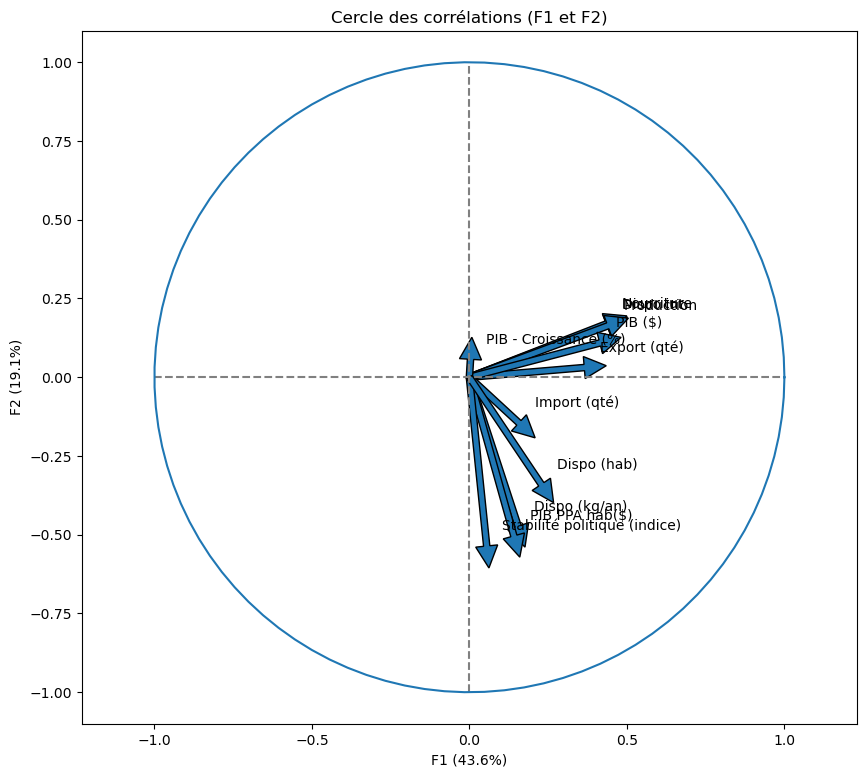

In [86]:
# Représenter le cercle des corrélations entre composante 1 et 2
fig = correlation_viz(pca, 0, 1, variables)
fig.savefig('cercles des corrélation F1 F2.png', dpi=300)

Les variables sont majoritairement bien représentées.
La composante 1 est composée de Production, PIB, Nourriture , Export et Dispo intérieure. Elles sont positivement corrélées.
La stabilité politique, PIB PPA  et Dispo (kg) sont négativement corrélées et composent le plus la composante 2.

<Figure size 640x480 with 0 Axes>

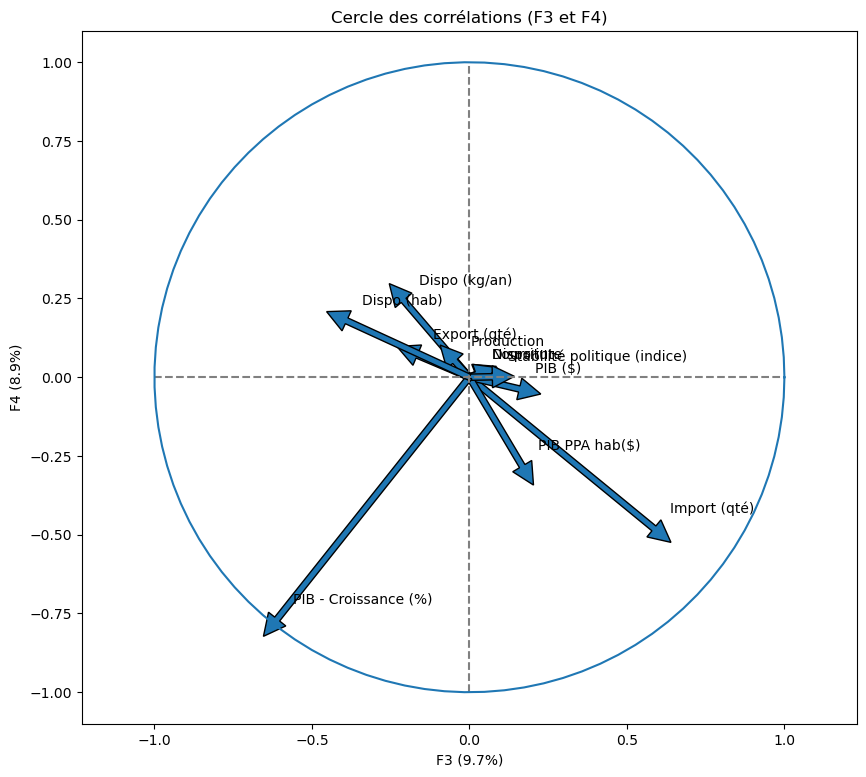

In [87]:
# Représenter le cercle des corrélations entre composante 3 et 4
fig = correlation_viz(pca, 2, 3, variables)
fig.savefig('cercles des corrélation F3 F4.png', dpi=300)

La composante 3 est majoritairement composée de Croissance PIB  et  Importation.
La composante 4 est composée de Dispo Kg et dispo par habitant.
Ces variables sont plutôt bien représentées sur le premier cercle des corréaltions (F1 et F2).
Ce cercle n'apporte rien de plus qu'au plan précédent, nous n'afficherons pas le plan factoriel
pour ces deux composantes qui ne représentent que 19% de la variance expliquée.

In [88]:
# Transformation en DataFrame pandas
df_pca_X = pd.DataFrame({
    "F1" : df_pca[:,0], 
    "F2" : df_pca[:,1],
    "F3" : df_pca[:,2], 
    "F4" : df_pca[:,3],
    "Zone" : bilan_fao_1["Zone"],
})

# Résultat (premières lignes)
df_pca_X.head()

,F1,F2,F3,F4,Zone
0,-1.252001,2.665765,0.285835,0.226425,Afghanistan
1,1.382024,-0.468872,-0.002677,-1.637898,Afrique du Sud
2,-0.872644,0.270033,-0.015561,-0.213494,Albanie
3,-0.794561,1.175887,0.119948,0.161766,Algérie
4,2.620779,-1.383752,2.903710,-2.265474,Allemagne


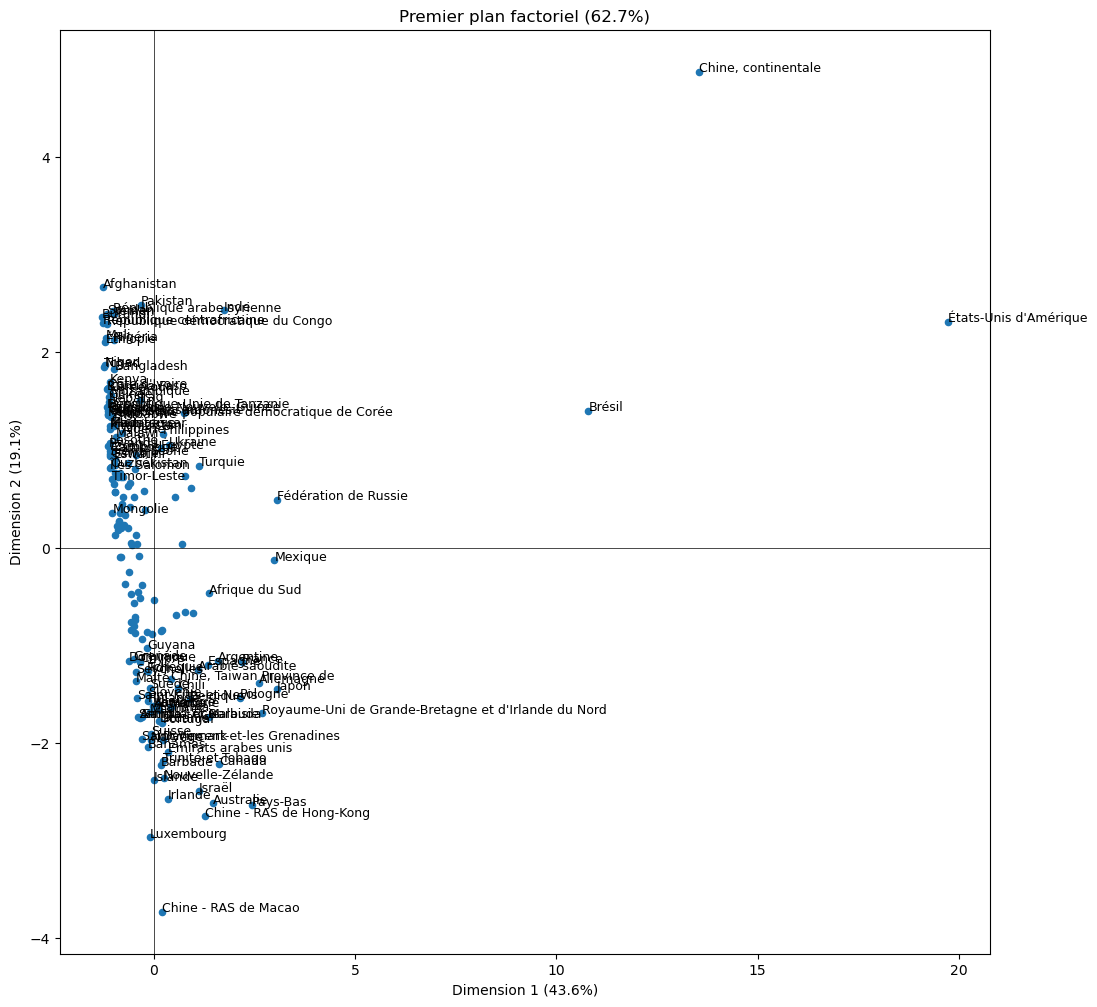

In [89]:
# Représenter les individus sur le plan factoriel (composante 1 et 2)
fig = plt.figure
fig, ax = plt.subplots(figsize=(12, 12))
df_pca_X.plot.scatter("F1", "F2", ax = ax)

for k in df_pca_X.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['F1']) > 1) | (abs(k[1]['F2']) > 1):
        ax.annotate(k[1]["Zone"], (k[1]['F1'], k[1]['F2']), fontsize = 9)

ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Dimension 1 (43.6%)") 
plt.ylabel("Dimension 2 (19.1%)")
plt.title("Premier plan factoriel (62.7%)")
plt.show()
fig.savefig("Premier plan factoriel.png", dpi=300)

<div style="background-color: RGB(217, 117, 26);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">V - CAH sur les composantes</h2>
</div>

In [90]:
# Calcul de la matrice de similarité/dissimilarité
linkage_matrix = linkage(X_scaled_pca, method='ward', metric='euclidean')

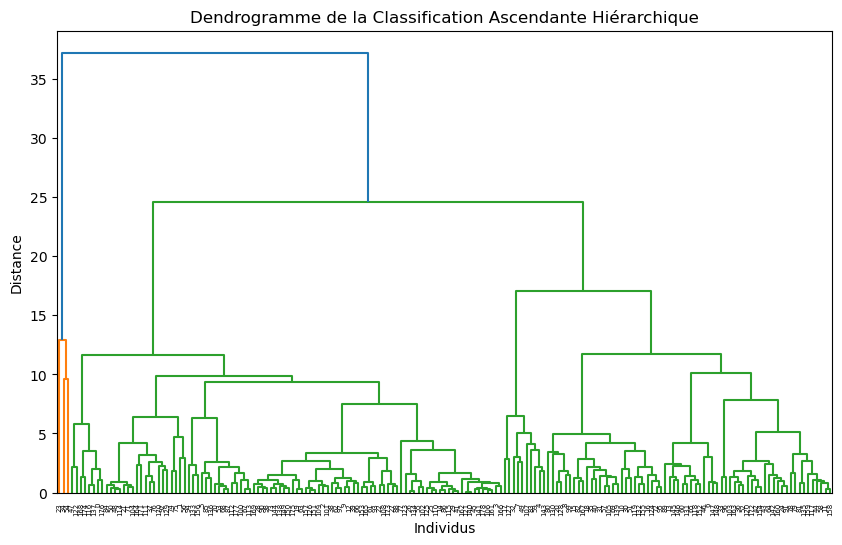

In [91]:
# Dendrogram
fig = dendrogram_viz(linkage_matrix)
fig.savefig('dendrogram_3.png', dpi=300)

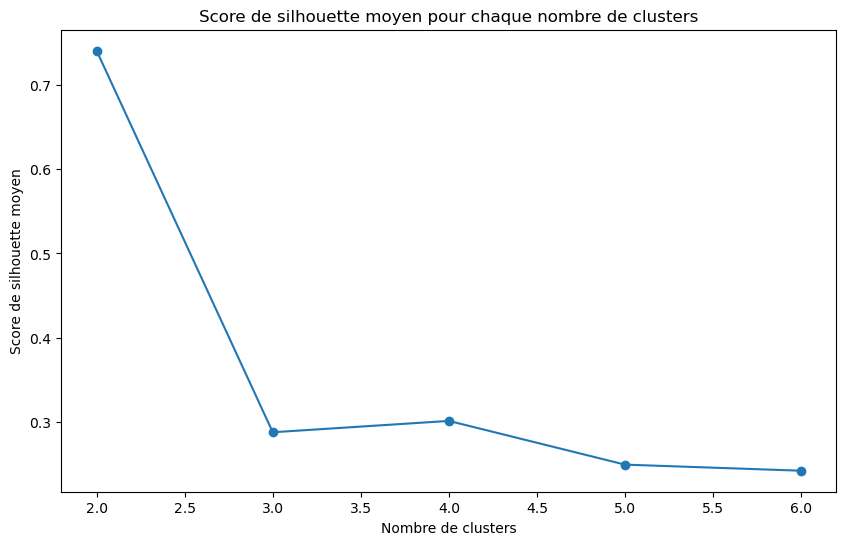

In [92]:
# Score de silhouette
fig = silhouette_coeff(6,X_scaled)
fig.savefig('silhouette_3.png', dpi=300)

In [93]:
# Définir le nombre de clusters
num_clusters = 3
clusters_3 = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
num_clusters = 4
clusters_4 = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
num_clusters = 5
clusters_5 = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
num_clusters = 6
clusters_6 = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

In [94]:
# Calculer le score de silhouette
print("Score de silhouette - 3 clusters :", round(silhouette_score(X_scaled, clusters_3),3))
print("Score de silhouette - 4 clusters :", round(silhouette_score(X_scaled, clusters_4),3))
print("Score de silhouette - 5 clusters :", round(silhouette_score(X_scaled, clusters_5),3))
print("Score de silhouette - 6 clusters :", round(silhouette_score(X_scaled, clusters_6),3))

Score de silhouette - 3 clusters : 0.287
Score de silhouette - 4 clusters : 0.299
Score de silhouette - 5 clusters : 0.298
Score de silhouette - 6 clusters : 0.268


In [95]:
# Définir nombre de clusters
num_clusters = 4

# Effectuer la CAH avec le nombre de clusters choisi
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Ajouter les informations de cluster dans le DataFrame
bilan_fao_1['Cluster_v3'] = clusters
X['Cluster_v3'] = clusters

# Afficher les statistiques des clusters
cluster_stats = bilan_fao_1.groupby('Cluster_v3').mean()
cluster_stats = cluster_stats.drop(['Code zone','Cluster_v2'], axis=1)
cluster_stats

,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%)
Cluster_v3,,,,,,,,,,,,,,
1,6.513135e+08,38.406667,15276.000000,2830.333333,192.666667,15333.00,18162.333333,49.510636,1.333333,29545.400000,-0.136667,1.128378e+07,9.562649,8.771355
2,4.362457e+07,10.745500,363.010000,18.220000,40.640000,360.94,352.900000,7.500914,3.210000,7551.105000,-0.648600,1.260387e+05,8.242924,6.448265
3,5.448442e+07,26.824000,1472.200000,434.600000,729.700000,1423.50,1275.000000,24.699157,4.500000,48784.860000,0.373000,1.781125e+06,5.008617,4.313053
4,9.587737e+06,34.215303,315.969697,48.318182,52.560606,304.00,325.575758,25.658653,4.696970,33042.704545,0.634242,2.481204e+05,7.455301,6.750210


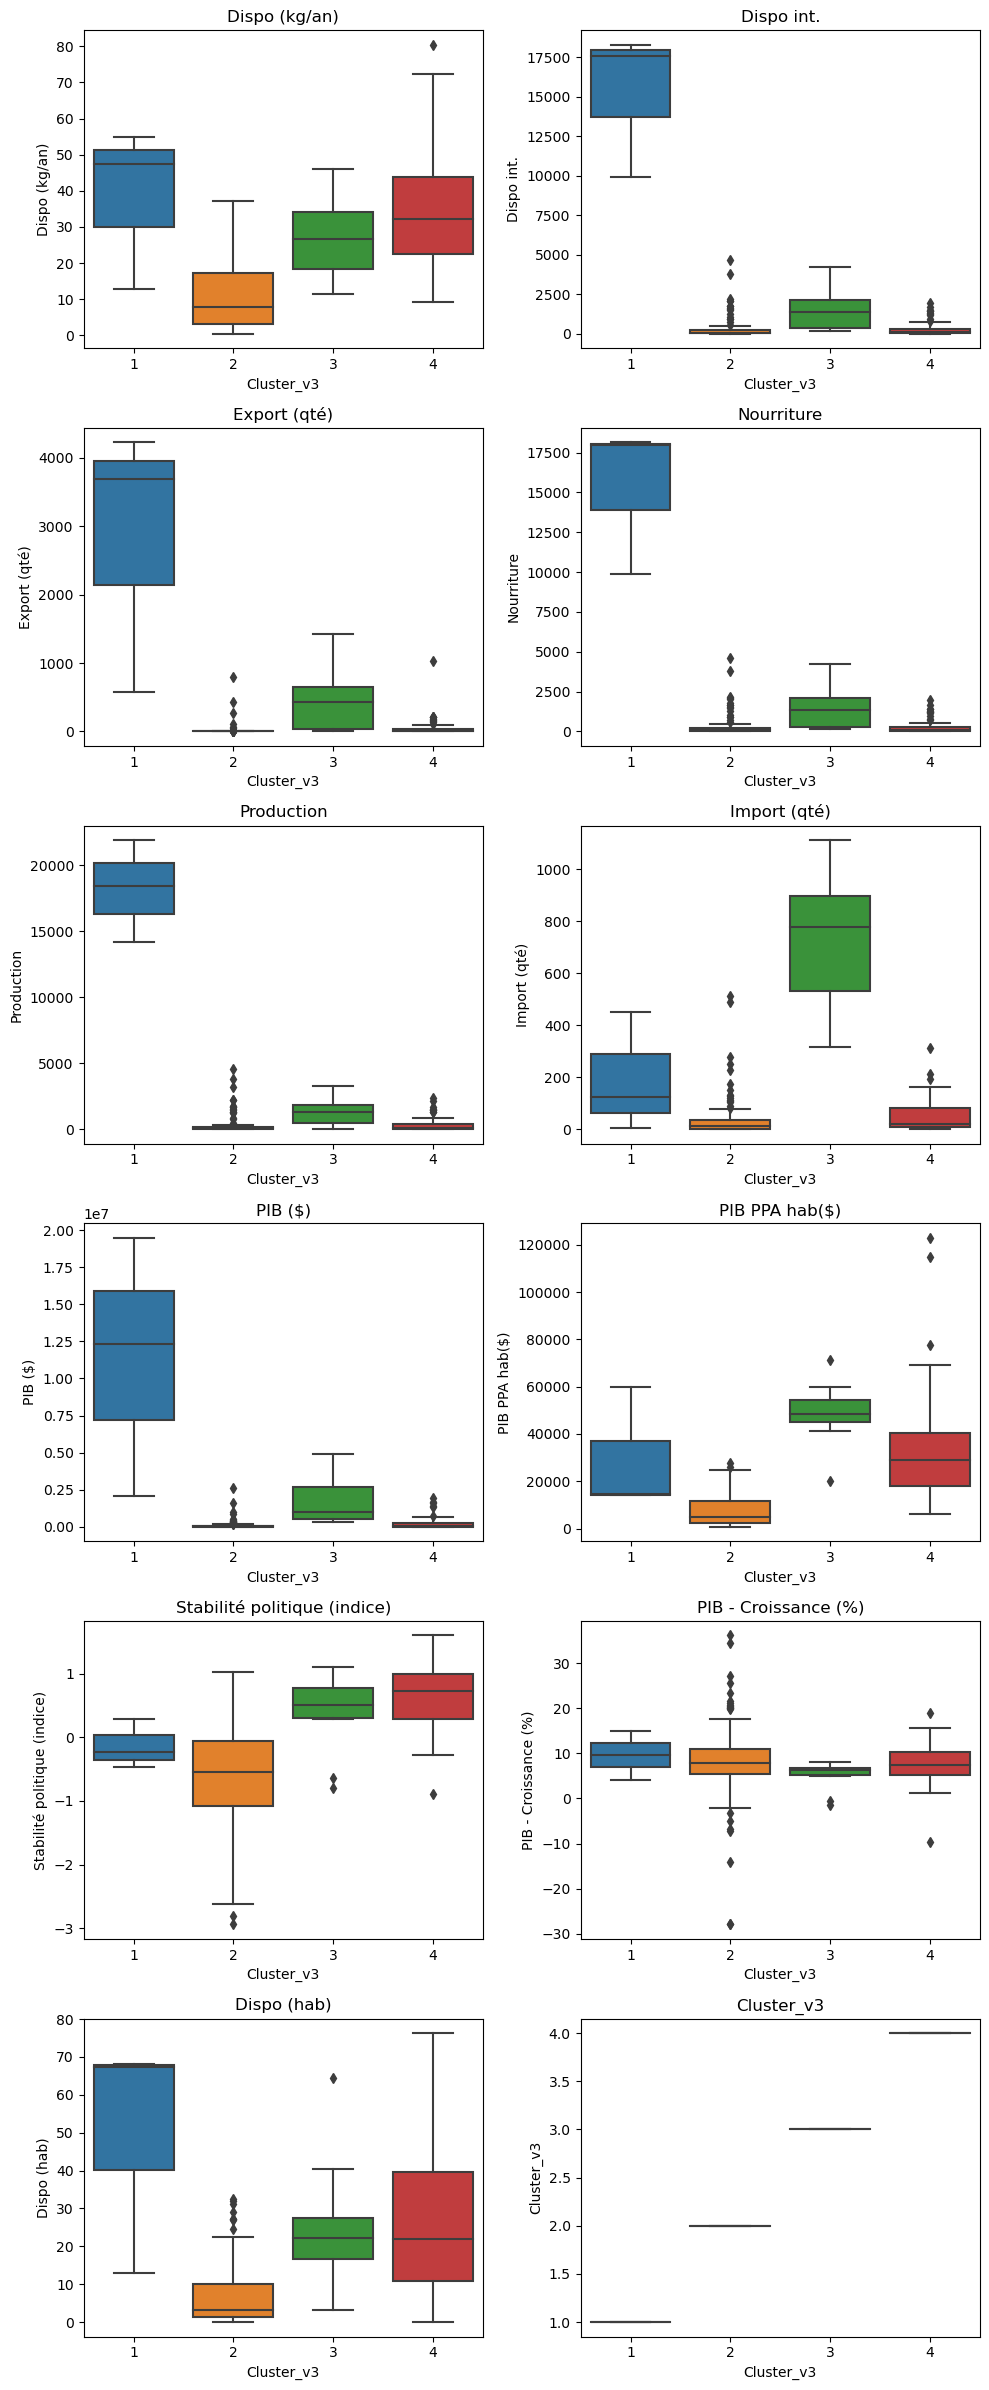

In [96]:
# Représenter la composition des clusters par des Boxplot par variables
fig = boxplot_1(X, X.Cluster_v3)
fig.savefig('boxplot_3.png', dpi=300)

In [97]:
# Afficher le contenu de chaque cluster
for i in range(1, 5) : 
    sub_df = bilan_fao_1.loc[bilan_fao_1.Cluster_v3 == i]

    print(f"cluster : {i}")

    zone_list = sub_df.Zone.values

    txt = [f"{n}" for n in zone_list]

    txt = " / ".join(txt)

    print(txt)
    print("\n")

cluster : 1
Brésil / Chine, continentale / États-Unis d'Amérique


cluster : 2
Afghanistan / Afrique du Sud / Albanie / Algérie / Angola / Arménie / Azerbaïdjan / Bangladesh / Bénin / Bosnie-Herzégovine / Botswana / Burkina Faso / Burundi / Cabo Verde / Cambodge / Cameroun / Colombie / Comores / Congo / Côte d'Ivoire / Djibouti / Égypte / El Salvador / Équateur / Eswatini / Éthiopie / Fédération de Russie / Gambie / Géorgie / Ghana / Guatemala / Guinée / Guinée-Bissau / Haïti / Honduras / Îles Salomon / Inde / Indonésie / Iran (République islamique d') / Iraq / Jordanie / Kazakhstan / Kenya / Kirghizistan / Kiribati / Lesotho / Liban / Libéria / Libye / Macédoine du Nord / Madagascar / Malawi / Maldives / Mali / Maroc / Mauritanie / Mongolie / Monténégro / Mozambique / Myanmar / Namibie / Népal / Nicaragua / Niger / Nigéria / Ouganda / Ouzbékistan / Pakistan / Papouasie-Nouvelle-Guinée / Paraguay / Philippines / République arabe syrienne / République centrafricaine / République de Mold

In [98]:
# Homogénéité et variance des clusters
kmeans = KMeans(n_clusters=4, random_state=50)
y1_pred = kmeans.fit_predict(X_scaled)
y1_true = X.Cluster_v3

hom_3 = round(homogeneity_score(y1_true, y1_pred),3)
print("Homogeneity score:", hom_3)

cal_3 = round(calinski_harabasz_score(X_scaled, clusters),3)
print("Calinski Harabasz Score :", cal_3)

print("\nLa variance est moins bonne qu'à l'essai précédent mais l'homogénéité des clusters est quasiment parfaite, "
      "Les clusters sont plus segmentés et donc plus précis. Les pays cible sont plus différencié par leur stabilité politique, "
      "leur PIB, ce qui n'était pas le cas aupravant. "
      "On effectue une Kmeans pour encore maximiser le résultat de ce clustering.")

Homogeneity score: 0.861
Calinski Harabasz Score : 61.95

La variance est moins bonne qu'à l'essai précédent mais l'homogénéité des clusters est quasiment parfaite, Les clusters sont plus segmentés et donc plus précis. Les pays cible sont plus différencié par leur stabilité politique, leur PIB, ce qui n'était pas le cas aupravant. On effectue une Kmeans pour encore maximiser le résultat de ce clustering.


<div style="background-color: RGB(217, 117, 26);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">VI - Kmeans sur les composantes</h2>
</div>

In [99]:
# Choix du nombre optimal de clusters (méthode du coude et du score de silhouette)
inertias = []
silhouettes = []
K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(X_scaled)
    inertias.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeanModel.labels_))

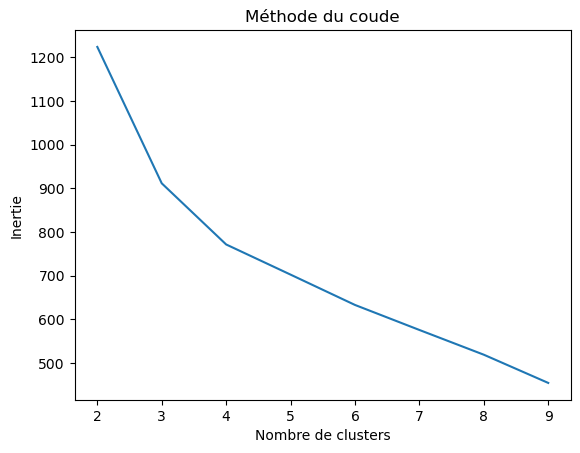

In [100]:
# Tracer la courbe de l'inertie en fonction du nombre de clusters
fig = plt.figure()
plt.plot(range(2, 10), inertias)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()
fig.savefig('Elbow.png')

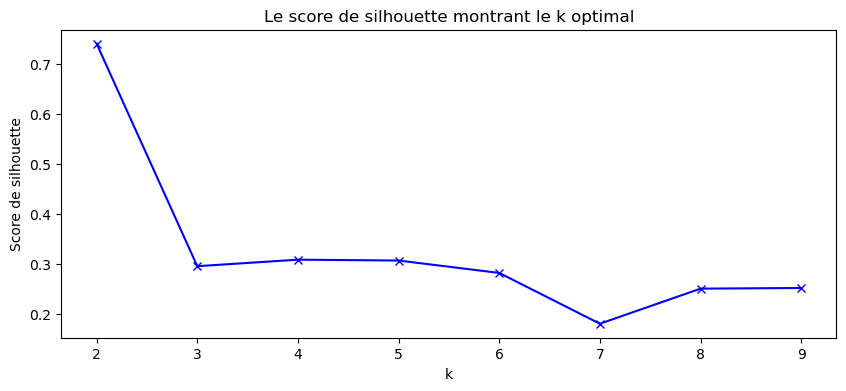

In [101]:
# Graphique du score de silhouette
fig = plt.figure(figsize=(10,4))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()
fig.savefig('Silhouette_kmeans.png')

In [102]:
# Calculer le silhouette score pour chaque cluster
range_n_clusters = list(range(2,7))
print ("Number of clusters from 2 to 6: \n", range_n_clusters)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters).fit(X_scaled)
    preds = clusterer.predict(X_scaled)
    centers = clusterer.cluster_centers_
    score = round(silhouette_score(X_scaled, preds, metric='euclidean'),3)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

Number of clusters from 2 to 6: 
 [2, 3, 4, 5, 6]
For n_clusters = 2, silhouette score is 0.741)
For n_clusters = 3, silhouette score is 0.295)
For n_clusters = 4, silhouette score is 0.308)
For n_clusters = 5, silhouette score is 0.304)
For n_clusters = 6, silhouette score is 0.281)


In [103]:
# Appliquer KMeans avec le nombre de clusters optimal trouvé (supposons que c'est 3 pour cet exemple)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=4, random_state=42)

In [104]:
bilan_fao_1['Cluster_v3_k'] = kmeans.labels_
X['Cluster_v3_k'] = kmeans.labels_

In [105]:
cluster_stats = bilan_fao_1.groupby('Cluster_v3_k')[X.columns].mean()
cluster_stats = cluster_stats.drop(['Cluster_v3', 'Cluster_v3_k'], axis=1)
round(cluster_stats,2)

,Dispo (kg/an),Dispo int.,Export (qté),Nourriture,Production,Import (qté),PIB ($),PIB PPA hab($),Stabilité politique (indice),PIB - Croissance (%),Dispo (hab)
Cluster_v3_k,,,,,,,,,,,
0,10.29,282.91,16.61,281.04,278.34,33.60,105213.11,7459.43,-0.63,8.00,6.76
1,29.41,1667.50,375.30,1621.60,1395.20,749.60,1768933.24,45135.68,0.30,6.21,23.57
2,38.41,15276.00,2830.33,15333.00,18162.33,192.67,11283781.21,29545.40,-0.14,9.56,49.51
3,34.16,405.88,59.10,393.34,418.21,59.82,278890.01,33342.34,0.60,7.65,26.65


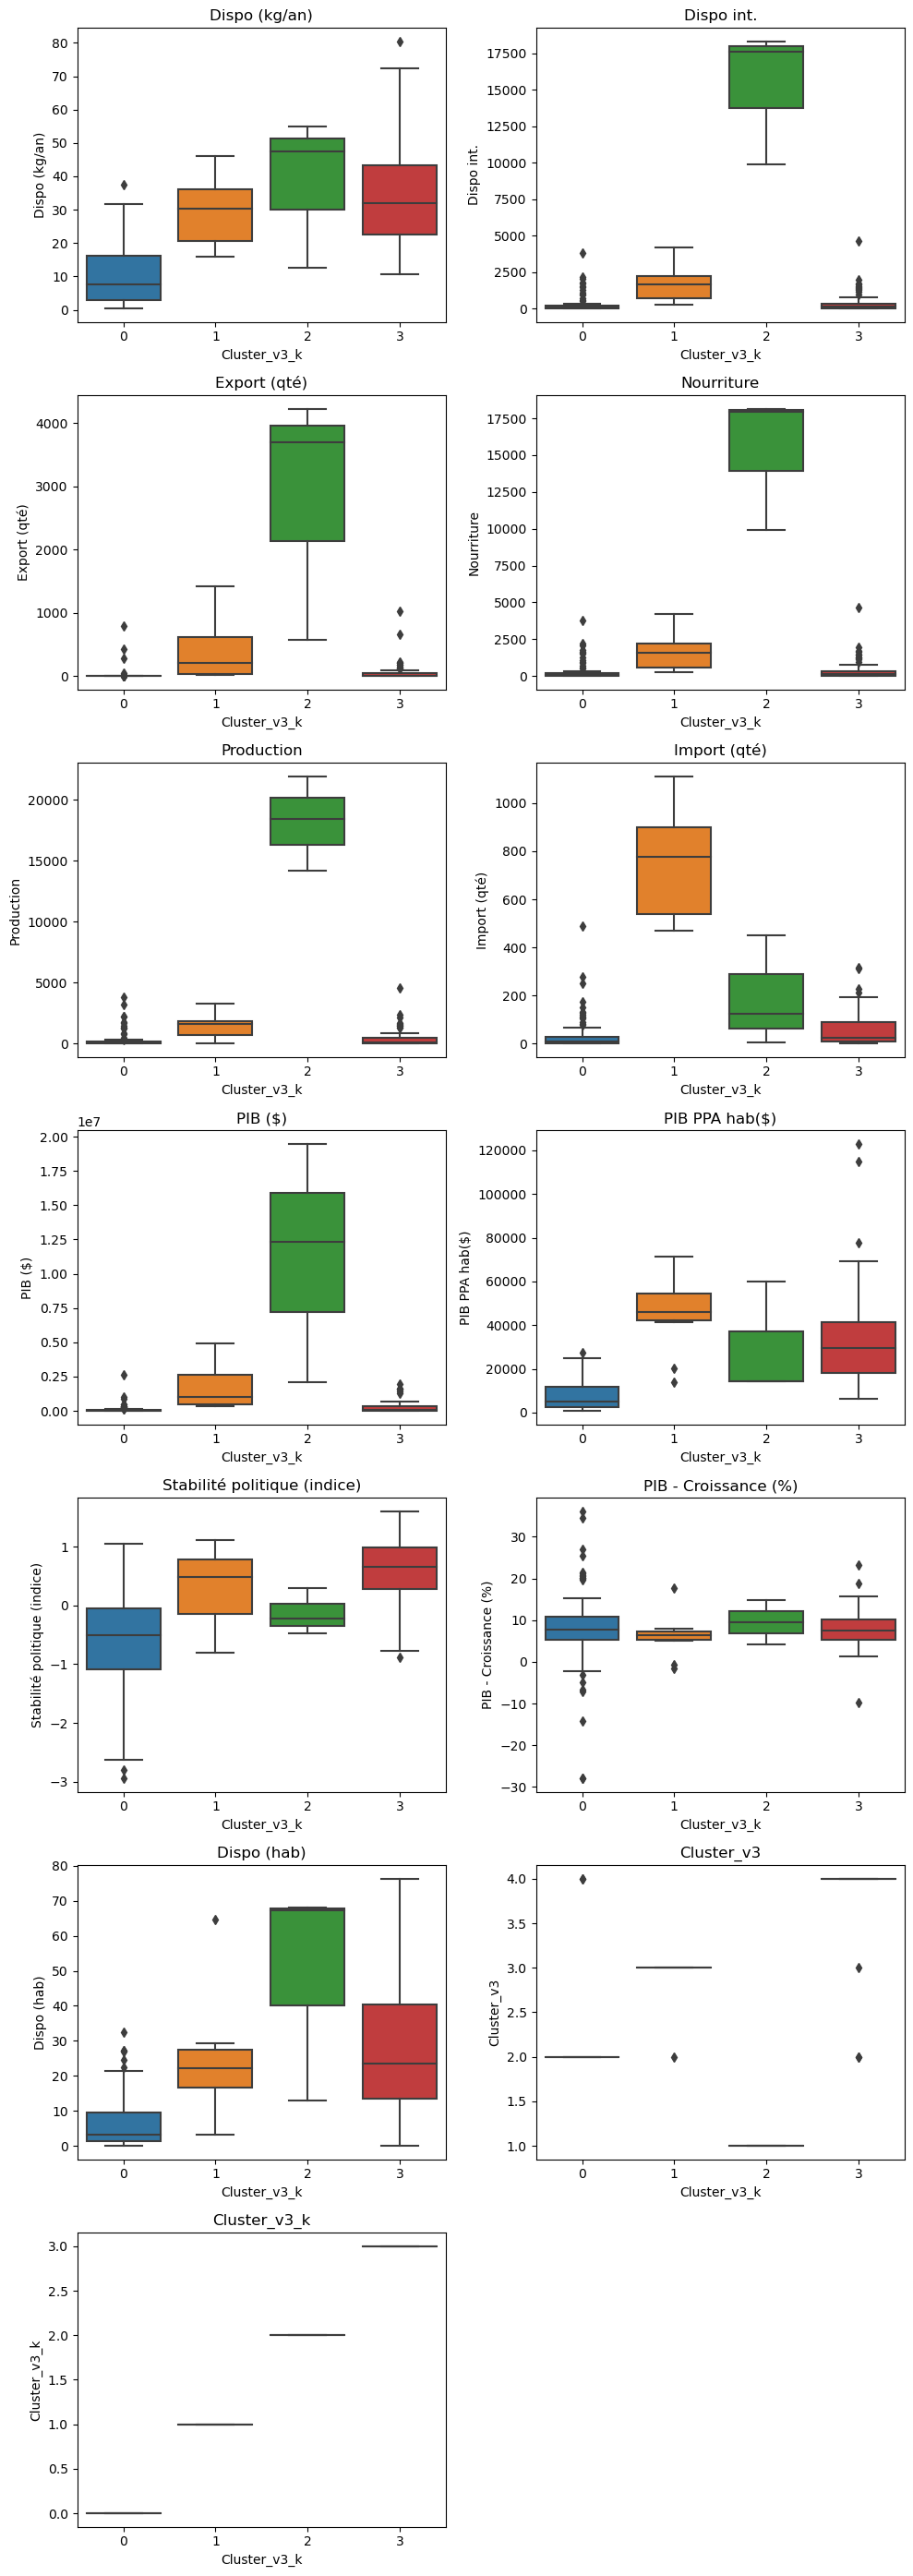

In [106]:
# Représenter la composition des clusters par des Boxplot par variables
fig = boxplot_1(X, X.Cluster_v3_k)
fig.savefig('boxplot_k.png', dpi=300)

In [107]:
# Afficher le contenu de chaque cluster
for i in range(0, 4) : 
    sub_df = bilan_fao_1.loc[bilan_fao_1.Cluster_v3_k == i]

    print(f"cluster : {i}")

    zone_list = sub_df.Zone.values

    txt = [f"{n}" for n in zone_list]

    txt = " / ".join(txt)

    print(txt)
    print("\n")

cluster : 0
Afghanistan / Albanie / Algérie / Angola / Arménie / Azerbaïdjan / Bangladesh / Bénin / Bosnie-Herzégovine / Botswana / Burkina Faso / Burundi / Cabo Verde / Cambodge / Cameroun / Comores / Congo / Côte d'Ivoire / Djibouti / Égypte / El Salvador / Équateur / Eswatini / Éthiopie / Gabon / Gambie / Géorgie / Ghana / Guatemala / Guinée / Guinée-Bissau / Haïti / Honduras / Îles Salomon / Inde / Indonésie / Iran (République islamique d') / Iraq / Jordanie / Kazakhstan / Kenya / Kirghizistan / Kiribati / Lesotho / Liban / Libéria / Libye / Macédoine du Nord / Madagascar / Malawi / Maldives / Mali / Maroc / Mauritanie / Mongolie / Monténégro / Mozambique / Myanmar / Namibie / Népal / Nicaragua / Niger / Nigéria / Ouganda / Ouzbékistan / Pakistan / Papouasie-Nouvelle-Guinée / Paraguay / Philippines / République arabe syrienne / République centrafricaine / République de Moldova / République démocratique du Congo / République démocratique populaire lao / République populaire démocrat

In [108]:
# Homogénéité et variance des clusters
from sklearn.metrics.cluster import homogeneity_score
kmeans = KMeans(n_clusters=4, random_state=50)
y1_pred = kmeans.fit_predict(X_scaled)
y1_true = X.Cluster_v3_k

hom_4 = round(homogeneity_score(y1_true, y1_pred),3)
print("Homogeneity score:", hom_4)

cal_4 = round(calinski_harabasz_score(X_scaled, clusters),3)
print("Calinski Harabasz Score :", cal_4)

print("\nLa variance est moins bonne mais l'homogénéité des clusters est quasi parfaite. Les clusters étant affinés, "
      " On peut en déduire que les clusters 1 et 2 ne seront pas interessant pour l'export. \nNous "
      "serons probablement interressé par le cluster 3 qui a une faible production, une faible importation "
      " de poulet mais une stabilité politique et un PIB PPA par habitant qui permettent la mise en place d'une exportation "
      " dans ces pays contrairement au cluster 0. ")

Homogeneity score: 0.969
Calinski Harabasz Score : 61.95

La variance est moins bonne mais l'homogénéité des clusters est quasi parfaite. Les clusters étant affinés,  On peut en déduire que les clusters 1 et 2 ne seront pas interessant pour l'export. 
Nous serons probablement interressé par le cluster 3 qui a une faible production, une faible importation  de poulet mais une stabilité politique et un PIB PPA par habitant qui permettent la mise en place d'une exportation  dans ces pays contrairement au cluster 0. 


<div style="background-color: RGB(217, 117, 26);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">VII - Choix et représentation des clusters</h2>
</div>

In [109]:
# Comparer les différents essais
print('Première définition de clusters :\n', bilan_fao_1.Cluster.value_counts(),
      '\nHomogeneity :', hom_1, 'Calinski :', cal_1,
     '\n\nDeuxième définition de clusters :\n',bilan_fao_1.Cluster_v2.value_counts(),
      '\nHomogeneity :', hom_2, 'Calinski :', cal_2,
     '\n\nTroisième définition de clusters :\n',bilan_fao_1.Cluster_v3.value_counts(),
      '\nHomogeneity :', hom_3, 'Calinski :', cal_3,
     '\n\nQuatrième définition de clusters :\n',bilan_fao_1.Cluster_v3_k.value_counts(),
     '\nHomogeneity :', hom_4, 'Calinski :', cal_4,)

Première définition de clusters :
 3.0    118
6.0     38
5.0     14
4.0      6
1.0      2
2.0      1
Name: Cluster, dtype: int64 
Homogeneity : 0.828 Calinski : 116.382 

Deuxième définition de clusters :
 2    101
4     67
3      8
1      3
Name: Cluster_v2, dtype: int64 
Homogeneity : 0.849 Calinski : 60.608 

Troisième définition de clusters :
 2    100
4     66
3     10
1      3
Name: Cluster_v3, dtype: int64 
Homogeneity : 0.861 Calinski : 61.95 

Quatrième définition de clusters :
 0    99
3    67
1    10
2     3
Name: Cluster_v3_k, dtype: int64 
Homogeneity : 0.969 Calinski : 61.95


D'après les scores des différents essais ci-dessus, nous retriendrons 
la classification par KMeans puisque c'est la méthode qui optimisé les clusters (homogénéité + variance). 

In [110]:
import geoplot as gplt
import geopandas as gpd

# Télécharger le fichier contenant les emplacements pays via geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).drop(['pop_est', 'gdp_md_est'], axis=1)
world.rename(columns={'name': 'Zone'}, inplace=True)

# Télécharger la correspondance Pays-code ISO pour croisement avec le fichier geopanda. Source FAO
country = pd.read_csv('pays_iso.csv', sep=";")
country = country.replace(["Pays-Bas (Royaume des)"], "Pays-Bas")

In [111]:
# Jointure entre pays et df utlisé pour l'analyse
bilan_country = pd.merge(country, bilan_fao_1, how='outer',on='Zone', indicator=True)

In [112]:
bilan_country._merge.value_counts()

both          179
left_only       1
right_only      0
Name: _merge, dtype: int64

In [113]:
# Contrôle des left_only (comme vu précédement, cette ligne représente les totaux de tous les pays formant la Chine)
bilan_country.loc[bilan_country['_merge'] == 'left_only']

,Code zone_x,Zone,Code zone_y,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,...,Cluster,PIB PPA hab($),Stabilité politique (indice),PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),Cluster_v2,Cluster_v3,Cluster_v3_k,_merge
32,F351,Chine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [114]:
# Ne garder que les both, Supprimer colonne merge
bilan_country = bilan_country.loc[bilan_country["_merge"] == "both"]
bilan_country = bilan_country.drop(["_merge"], axis=1)

In [115]:
# Renommer colonnes
bilan_country.rename(columns={'Code zone_x': 'iso_a3', 'Code zone_y': 'Code zone'}, inplace=True)
bilan_country

,iso_a3,Zone,Code zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,Dispo (hab),Cluster,PIB PPA hab($),Stabilité politique (indice),PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),Cluster_v2,Cluster_v3,Cluster_v3_k
0,AFG,Afghanistan,2.0,36296113.0,1.79,64.0,0.0,29.0,64.0,28.0,0.771432,3.0,2096.1,-2.80,1.889635e+04,4.865789,1.902494,2.0,2.0,0.0
1,ZAF,Afrique du Sud,202.0,57009756.0,37.25,2110.0,63.0,514.0,2110.0,1665.0,29.205528,6.0,13950.5,-0.28,3.808514e+05,17.703799,17.248839,2.0,2.0,1.0
2,ALB,Albanie,3.0,2884169.0,11.55,33.0,0.0,20.0,33.0,13.0,4.507364,3.0,12771.0,0.38,1.301973e+04,9.765943,9.831055,2.0,2.0,0.0
3,DZA,Algérie,4.0,41389189.0,6.95,286.0,0.0,2.0,286.0,284.0,6.861695,3.0,11809.5,-0.92,1.700970e+05,6.287892,4.228057,2.0,2.0,0.0
4,DEU,Allemagne,79.0,82658409.0,18.06,1557.0,646.0,842.0,1492.0,1514.0,18.316346,4.0,53071.5,0.59,3.690849e+06,6.441276,6.063881,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,VEN,Venezuela (République bolivarienne du),236.0,29402484.0,15.89,486.0,0.0,23.0,486.0,462.0,15.712958,3.0,12400.0,-1.27,2.479322e+05,-14.069328,-13.568785,2.0,2.0,0.0
176,VNM,Viet Nam,237.0,94600648.0,9.87,927.0,8.0,62.0,928.0,874.0,9.238837,3.0,9050.7,0.23,2.813536e+05,9.435232,8.380229,2.0,2.0,0.0
177,YEM,Yémen,249.0,27834819.0,8.41,253.0,0.0,82.0,253.0,171.0,6.143385,3.0,2300.0,-2.94,1.839165e+04,-1.798505,-4.284693,2.0,2.0,0.0
178,ZMB,Zambie,251.0,16853599.0,3.49,60.0,1.0,12.0,60.0,49.0,2.907391,3.0,3395.5,0.15,2.586816e+04,20.582767,16.886155,2.0,2.0,0.0


In [116]:
# Jointure fichier des emplacements Geopanda et notre df avec code ISO
geo = pd.merge(bilan_country,world, how='outer', on='iso_a3', indicator=True)

In [117]:
geo._merge.value_counts()

both          160
left_only      19
right_only     17
Name: _merge, dtype: int64

In [118]:
# Contrôle des left_only
geo.loc[geo['_merge'] == 'left_only']

,iso_a3,Zone_x,Code zone,Population,Dispo (kg/an),Dispo int.,Export (qté),Import (qté),Nourriture,Production,...,PIB ($),PIB - Croissance (%),PIB - Croissance par hab (%),Cluster_v2,Cluster_v3,Cluster_v3_k,continent,Zone_y,geometry,_merge
6,ATG,Antigua-et-Barbuda,8.0,95426.0,68.78,7.0,0.0,7.0,6.0,0.0,...,1467.977778,2.185223,1.562819,4.0,4.0,3.0,NaN,NaN,None,left_only
15,BRB,Barbade,14.0,286232.0,47.16,17.0,0.0,2.0,13.0,16.0,...,4981.588500,3.078466,2.879831,4.0,4.0,3.0,NaN,NaN,None,left_only
27,CPV,Cabo Verde,35.0,537498.0,23.30,13.0,0.0,12.0,13.0,1.0,...,1769.786532,6.420606,5.184896,2.0,2.0,0.0,NaN,NaN,None,left_only
32,HKG,Chine - RAS de Hong-Kong,96.0,7306322.0,46.09,237.0,664.0,917.0,344.0,24.0,...,341271.099990,6.361267,5.996462,3.0,3.0,1.0,NaN,NaN,None,left_only
33,MAC,Chine - RAS de Macao,128.0,622585.0,33.36,21.0,0.0,23.0,21.0,4.0,...,50440.935654,11.914870,9.825740,4.0,4.0,3.0,NaN,NaN,None,left_only
38,COM,Comores,45.0,813892.0,17.64,13.0,0.0,14.0,13.0,1.0,...,1077.439756,6.450871,4.294080,2.0,2.0,0.0,NaN,NaN,None,left_only
46,DMA,Dominique,55.0,71458.0,44.47,4.0,0.0,4.0,3.0,0.0,...,520.700000,-9.636719,-10.057712,4.0,4.0,3.0,NaN,NaN,None,left_only
65,GRD,Grenade,86.0,110874.0,42.47,8.0,0.0,7.0,5.0,1.0,...,1125.685977,6.032658,5.195242,4.0,4.0,3.0,NaN,NaN,None,left_only
88,KIR,Kiribati,83.0,114158.0,19.95,2.0,0.0,1.0,2.0,1.0,...,188.182032,5.426179,3.806623,2.0,2.0,0.0,NaN,NaN,None,left_only
101,MDV,Maldives,132.0,496402.0,15.24,12.0,0.0,12.0,7.0,0.0,...,4754.185598,8.564508,4.384548,2.0,2.0,0.0,NaN,NaN,None,left_only


Ces pays ne seront pas représentés. sur la carte car ils ne figurent pas sur le fichier Geopanda.

In [119]:
# Ne garder que les both, supprimer colonne merge
geo = geo.loc[geo["_merge"] == "both"]
geo = geo.drop(["_merge"], axis=1)

In [120]:
# Tranformer le df en GeoDataframe
geo = gpd.GeoDataFrame(geo)

<Figure size 1500x1000 with 0 Axes>

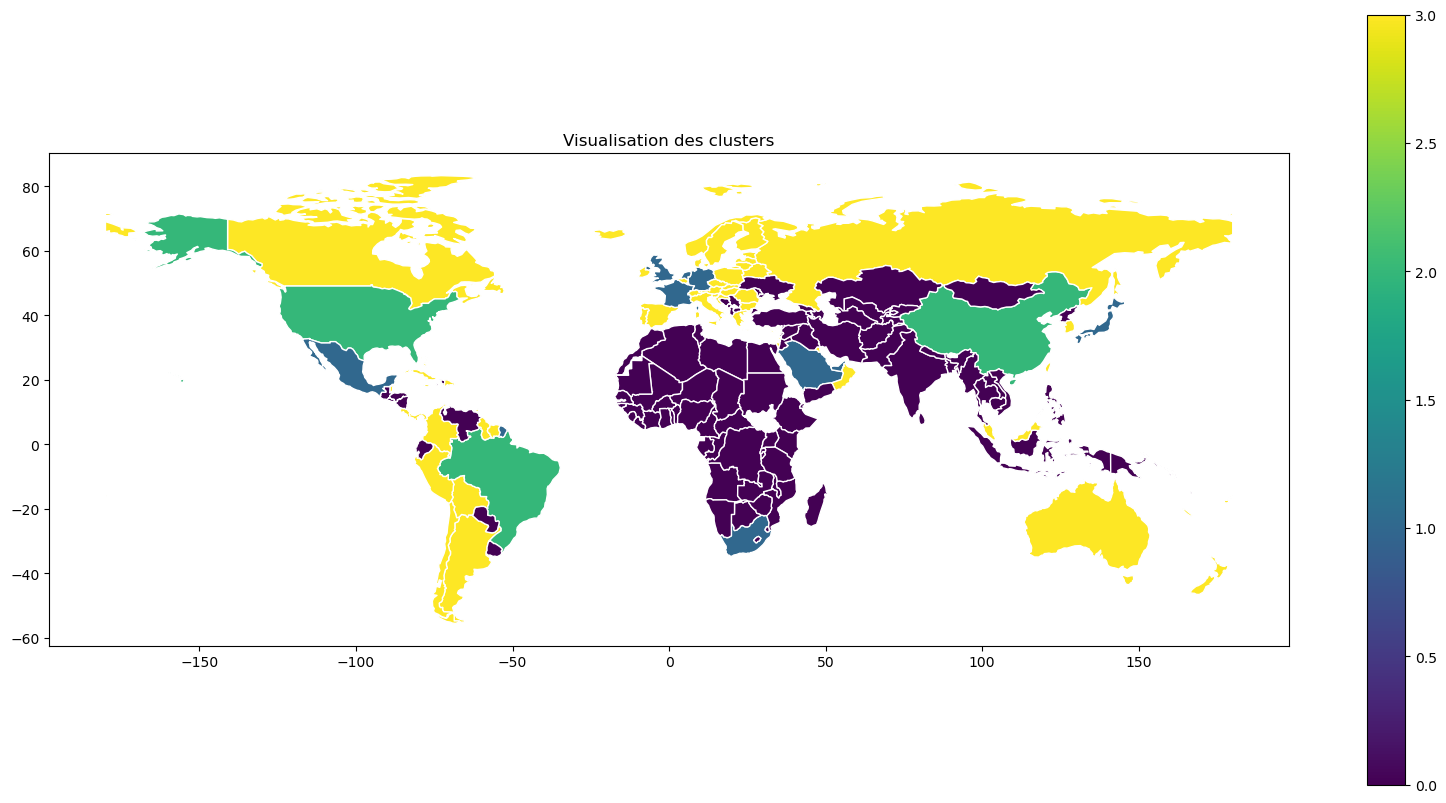

In [121]:
# Représenter les pays par clusters sur une carte
fig = plt.figure(figsize=(15,10))
geo.plot(
    column="Cluster_v3_k",
    legend=True,
    figsize=(20, 10),
    edgecolor='white', linewidth=1);
plt.title('Visualisation des clusters')
fig.savefig('carte.png', dpi=300)

Le cluster 3 ne représente pas un continent spécifique, il représente aussi bien des pays d'Europe, que d'Asie, que d'Amérique du Sud.